# R script to analyse population structure in the GLUE dataset 

## Setup

### Libraries required

In [38]:
# Load required packages
library(tidyverse)
library(wesanderson)
library(vegan)
library(umap)
library(IRdisplay)
library(SIBER)
library(dplyr)
library(lme4)
library(MASS)
library(glmmTMB)
library(ggrepel)
library(ggpubr)
library(MuMIn)
library(lmerTest)
library(DHARMa)

This is DHARMa 0.4.6. For overview type '?DHARMa'. For recent changes, type news(package = 'DHARMa')



In [3]:
# Path to results for this project
results_prefix <- '/scratch/projects/trifolium/glue/demography/glue_demography/results/'

In [4]:
# Function to calculate % variance and cummulative variance from PC
# Used to generate summary table rather than printing the lengthy `princomp()` summary
pca_importance <- function(x) {
  vars <- x$sdev^2
  vars <- vars/sum(vars)
  rbind(`Standard deviation` = x$sdev, `Proportion of Variance` = vars, 
      `Cumulative Proportion` = cumsum(vars))
}

### Order of samples in cov files

In [5]:
# File of samples order in the global analysis
samples<-read.csv("/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/resources/glue_noLowCities_sampleSheet_noRelated.txt", header=TRUE, sep="\t")
global <- read.table("/scratch/projects/trifolium/glue/demography/glue_demography/results/program_resources/bam_lists/withoutRelated/finalSamples_4fold_bams.list")
global$V1<-gsub("/scratch/projects/trifolium/glue/pc/results/bam/4fold/","",as.character(global$V1))
global$V1<-gsub("_4fold.bam","",as.character(global$V1))
global_order_detail<-merge(samples, global,  by.x="sample", by.y="V1", all.x=FALSE, all.y=TRUE, sort=FALSE) 
sample_name<-global_order_detail$sample

# File of samples order per city
list<-c("Albuquerque", "Antwerp", "Armidale","Athens","Buenos_Aires",
        "Calgary","Cape_Town","Christchurch","Kunming","Landshut","Linkoping","Loja","Memphis",
        "Mexico_City","Munich","Palmerston_North","Punta_Arenas","Quito","Sapporo","Tehran",
        "Thessaloniki","Toronto","Vancouver","Warsaw")
samples<-read.csv("/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/resources/glue_noLowCities_sampleSheet_noRelated.txt", header=TRUE, sep="\t")

for (city in list){
    samples<-read.csv("/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/resources/glue_noLowCities_sampleSheet_noRelated.txt", header=TRUE, sep="\t")
    detail <- read.table(paste0("/scratch/projects/trifolium/glue/demography/glue_demography/results/program_resources/bam_lists/by_city/withoutRelated/",city,"/",city,"_4fold_lowCovRemoved_bams.list"))
    head(detail)
    detail$V1<-gsub("/scratch/projects/trifolium/glue/pc/results/bam/4fold/","",as.character(detail$V1))
    detail$V1<-gsub("_4fold.bam","",as.character(detail$V1))
    name <-paste0(city,'_order_detail')
    tmp <-merge(samples, detail,  by.x="sample", by.y="V1", all.x=FALSE, all.y=TRUE, sort=FALSE) 
    assign(name,tmp)
    }




### Theme for plotting

In [6]:
# Theme used for plotting
ng2 <- theme(panel.background = element_blank(),
             #aspect.ratio=0.5,
             panel.grid.major = element_blank(),
             panel.grid.minor = element_blank(),
             panel.border=element_blank(),
             axis.line.x = element_line(color="black",size=1),
             axis.line.y = element_line(color="black",size=1),
             axis.ticks=element_line(size = 1, color="black"),
             axis.ticks.length=unit(0.25, 'cm'),
             axis.text=element_text(color="black",size=15),
             axis.title=element_text(color="black",size=1),
             axis.title.y=element_text(vjust=2,size=17),
             axis.text.x=element_text(size=15,angle = 45,hjust = 1),
             axis.text.y=element_text(size=15),
             strip.text.x = element_text(size = 15, colour = "black",face = "bold"),
             strip.background = element_rect(colour="black"),
             axis.title.x=element_blank(),
             legend.position = "top", 
             legend.direction="horizontal",
             legend.text=element_text(size=15), legend.key = element_rect(fill = "white"),
             legend.title = element_text(size=15),legend.key.size = unit(0.7, "cm"))

urban_col <- "#7b3294"
rural_col <- "#a6dba0"
cols <- c(urban_col, rural_col)

Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


# Global PCA and UMAPP

PCA and UMAPP analyses performed on the complete dataset minus low quality samples and related individuals (pairwise relatedness r>=0.5 (first degree relatedness : full-sib or parent offspring). A total of 168,209 4 fold SNPs were used for these analyses.

## PCA

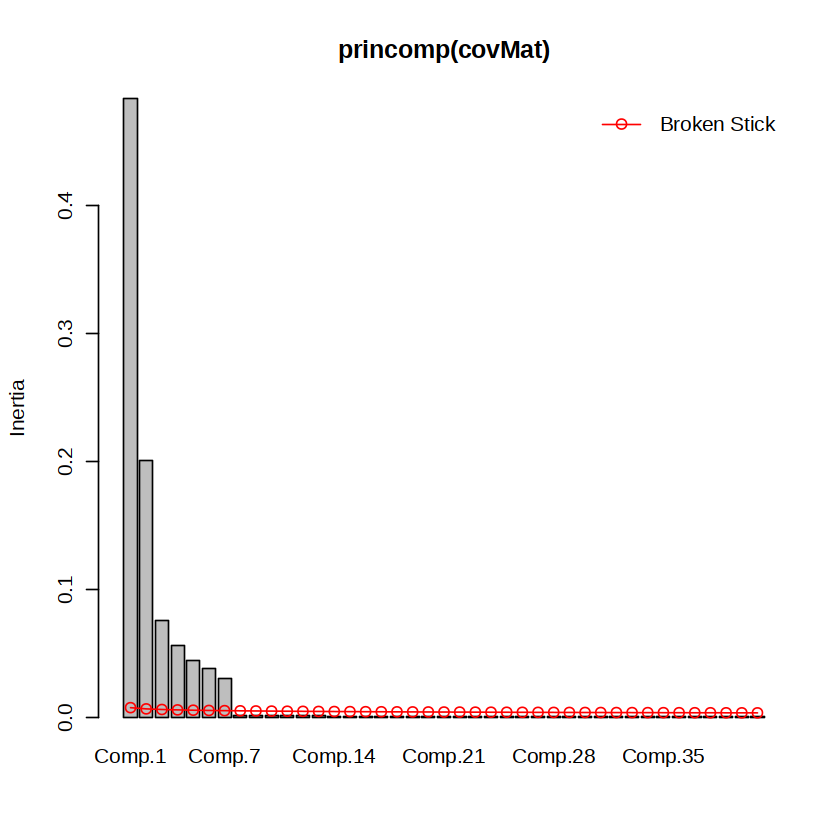

In [8]:
# Load covariance matrix
#covMat_path <- paste0(results_prefix, 'population_structure//pcangsd/allSamples/pcangsd_withoutRelated/allSamples_4fold_maf0.05_pcangsd.cov')
covMat<-as.matrix(read.table("/scratch/projects/trifolium/glue/demography/glue_demography/results/population_structure//pcangsd/allSamples/pcangsd_withoutRelated/allSamples_4fold_maf0.05_pcangsd.cov", sep=" "))

# Perform eigen decomposition of covariance matrix
# Extract eigenvectors and bind with sample sheet for plotting and coloring by habitat
eigenvectors <- eigen(covMat)
eigen_df <- eigenvectors$vectors %>%
        as.data.frame() %>%
        dplyr::select(V1, V2, V3, V4) %>%
        rename('PC1' = 'V1',
               'PC2' = 'V2',
               'PC3' = 'V3',
               'PC4' = 'V4') %>%
    bind_cols(., global_order_detail)
screeplot(princomp(covMat), bstick = TRUE, npcs=41)


In [9]:
# Percent Variance explained by first 4 PCs
pca_importance(summary(princomp(covMat))) %>% 
    as.data.frame() %>% 
    rownames_to_column('var') %>% 
    dplyr::select(var, Comp.1:Comp.8)

var                    Comp.1    Comp.2    Comp.3     Comp.4     Comp.5    
1 Standard deviation     0.6952056 0.4477291 0.27480906 0.23690243 0.21130037
2 Proportion of Variance 0.2574646 0.1067878 0.04023028 0.02989716 0.02378436
3 Cumulative Proportion  0.2574646 0.3642524 0.40448268 0.43437985 0.45816421
  Comp.6     Comp.7     Comp.8      
1 0.19595686 0.17431116 0.0429893949
2 0.02045559 0.01618607 0.0009844953
3 0.47861979 0.49480586 0.4957903533

### PCA plots

In [1]:
pca_plot1 <- eigen_df %>%
    ggplot(., aes(x = PC1, y = PC2, color = city, shape = site)) +
        geom_point(size = 4.5, alpha = 0.8) +
        theme_classic() +
        #stat_ellipse() +
        xlab('PC1 (25.7%)') + ylab('PC2 (10.7%)') +
        theme(axis.text = element_text(size = 16),
              axis.title = element_text(size = 20),
              legend.position = 'top')
pca_plot1

pca_plot2 <- eigen_df %>%
    ggplot(., aes(x = PC1, y = PC3, color = city, shape = site)) +
        geom_point(size = 4.5, alpha = 0.8) +
        theme_classic() +
        xlab('PC1 (25.7%)') + ylab('PC3 (4%)') +
        theme(axis.text = element_text(size = 16),
              axis.title = element_text(size = 20),
              legend.position = 'top')
pca_plot2

pca_plot3 <- eigen_df %>%
    ggplot(., aes(x = PC1, y = PC4, color = city, shape = site)) +
        geom_point(size = 4.5, alpha = 0.8) +
        theme_classic() +
        xlab('PC1 (25.7%)') + ylab('PC4 (3%)') +
        theme(axis.text = element_text(size = 16),
              axis.title = element_text(size = 20),
              legend.position = 'top')
pca_plot3

ggsave(
  "Global_PCA_PC1_PC2.png",
  plot = pca_plot1,
  device = png,
  path = "/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/pca",
  dpi = 300
)
#display_png(file="/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/pca/Global_PCA_PC1_PC2.png")

ggsave(
  "Global_PCA_PC1_PC3.png",
  plot = pca_plot2,
  device = png,
  path = "/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/pca",
  dpi = 300
)
#display_png(file="/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/pca/Global_PCA_PC1_PC3.png")

ggsave(
  "Global_PCA_PC1_PC4.png",
  plot = pca_plot3,
  device = png,
  path = "/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/pca",
  dpi = 300
)
#display_png(file="/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/pca/Global_PCA_PC1_PC4.png")


ERROR: Error in eigen_df %>% ggplot(., aes(x = PC1, y = PC2, color = city, shape = site)): impossible de trouver la fonction "%>%"


## Plot centroids PCA

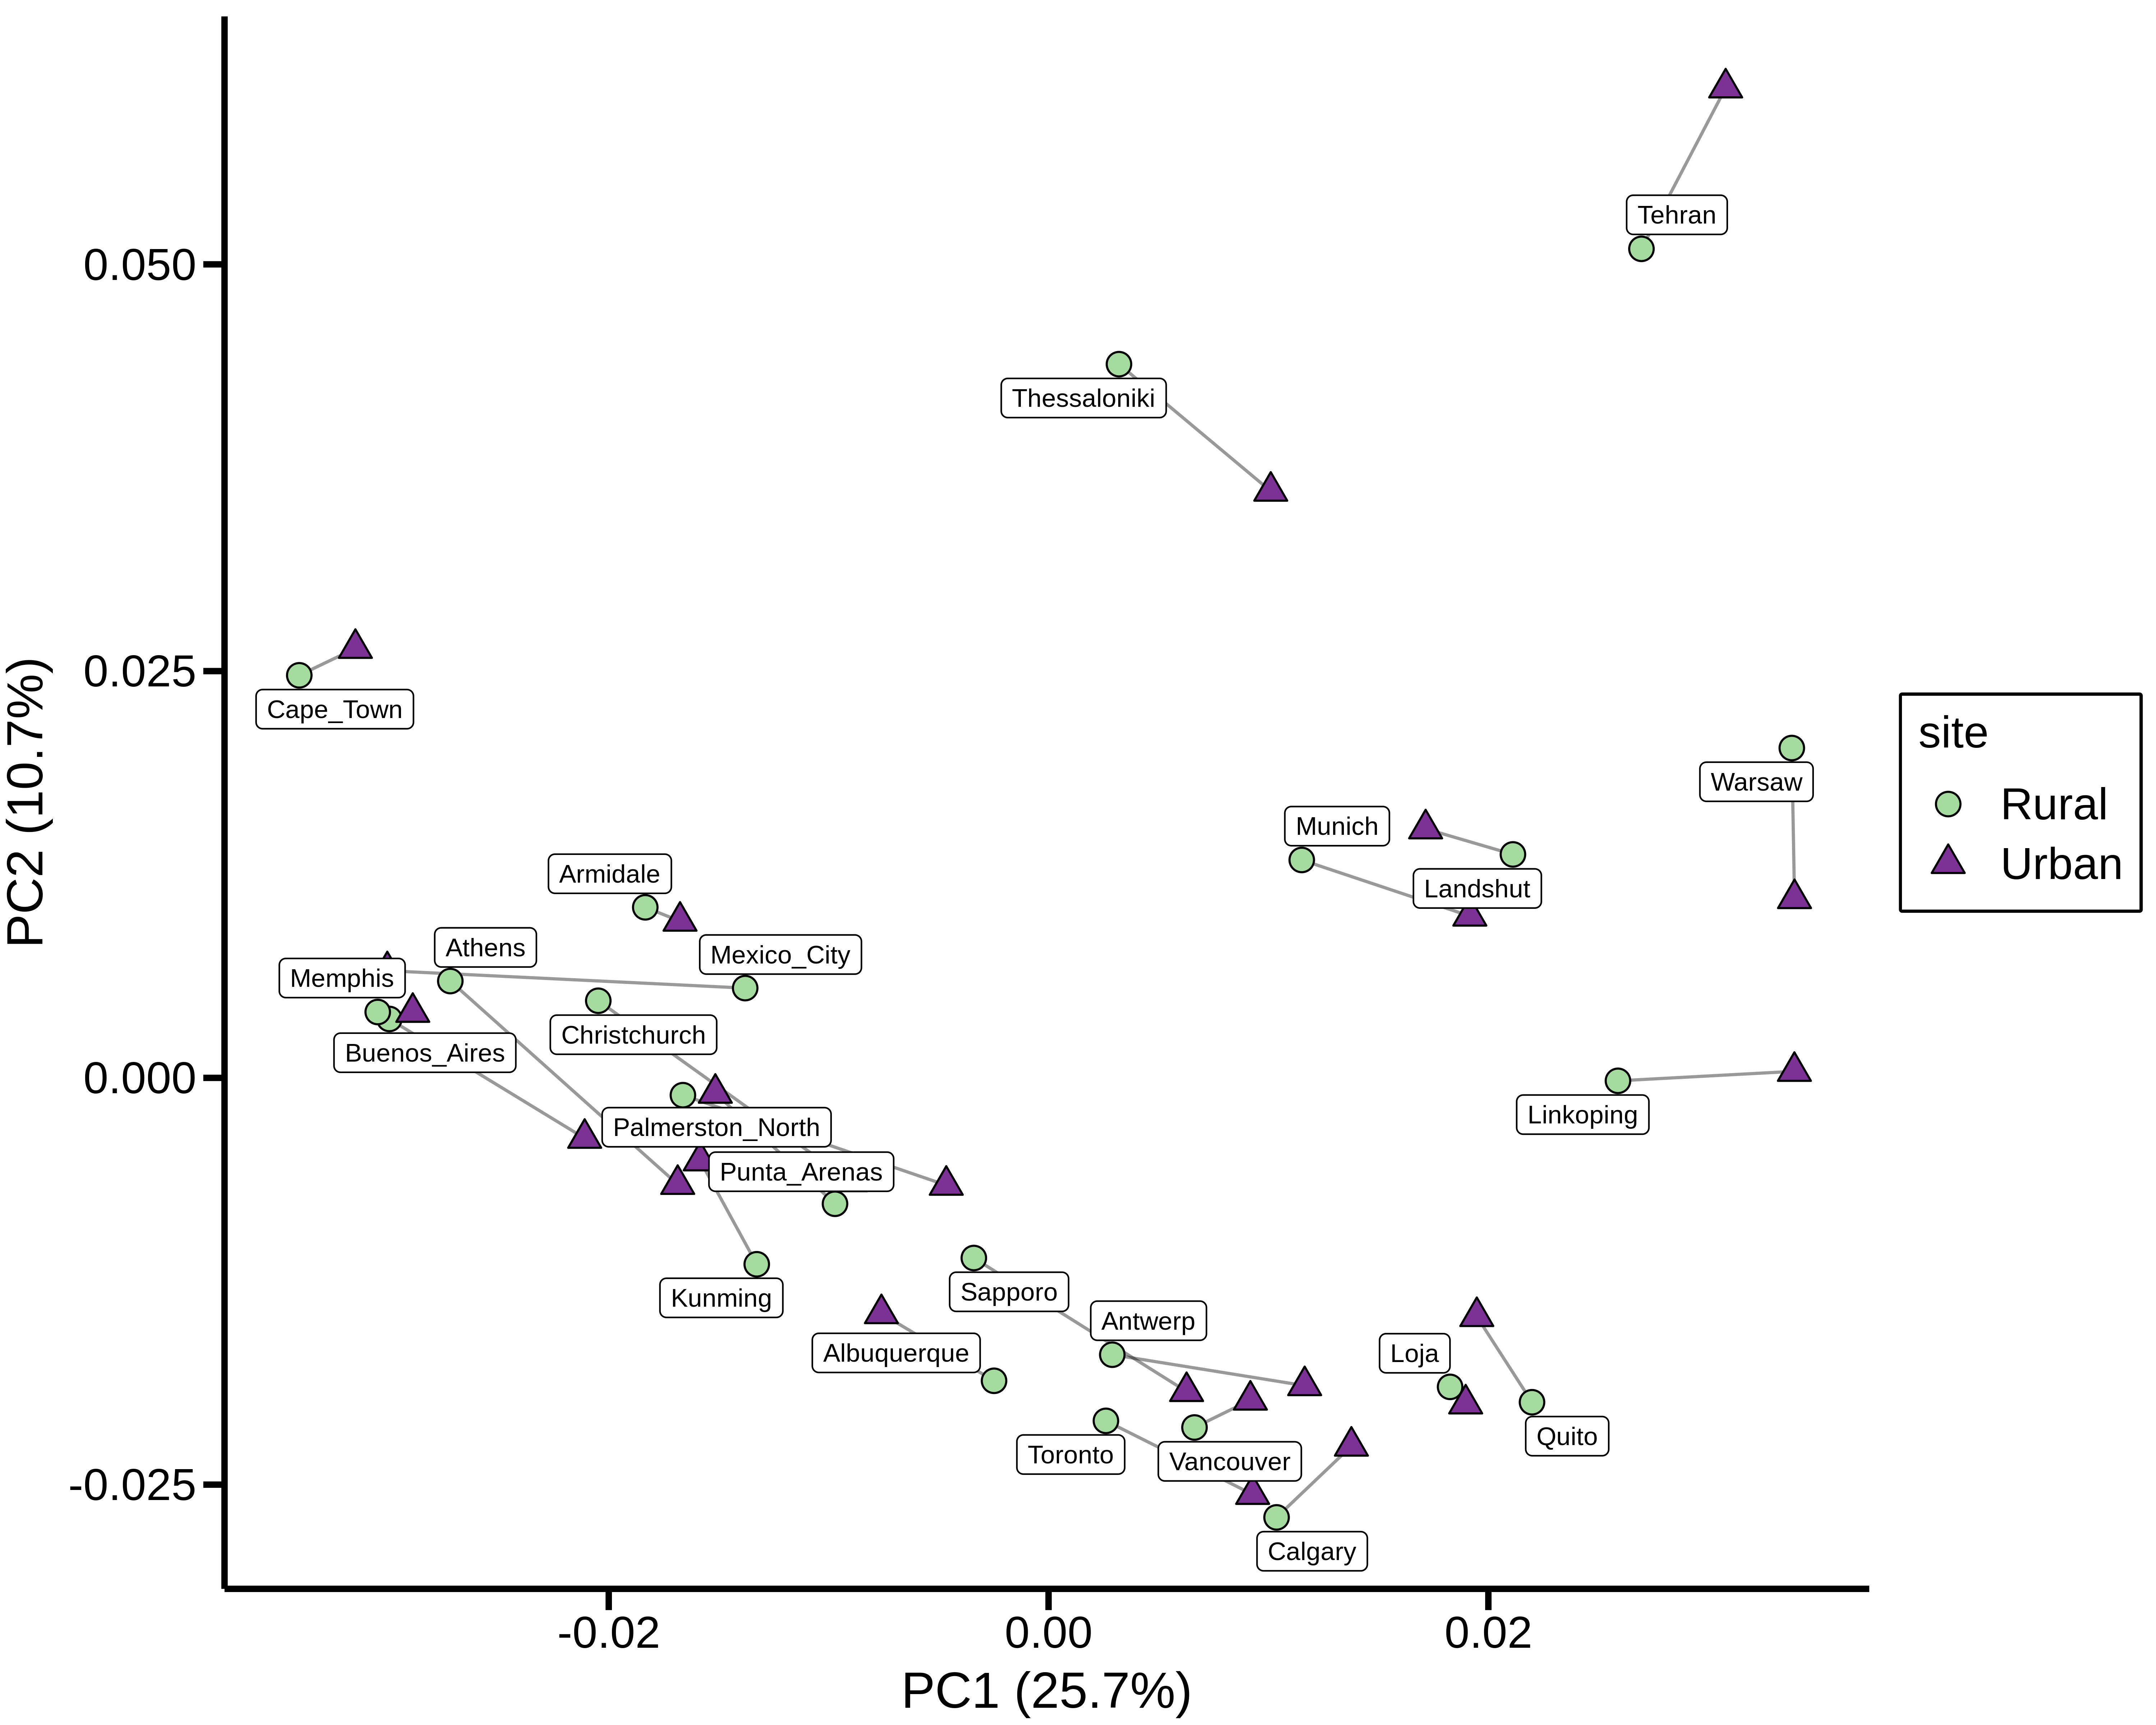

In [73]:
euc_dist_df_forPlot <- eigen_df %>% 
    group_by(city, site) %>% 
    summarise(x = mean(PC1),
              y = mean(PC2),
             .groups = 'drop')

pca_centroids <- euc_dist_df_forPlot %>%
    mutate(site = fct_recode(site, 'Rural' = 'r', 'Urban' = 'u')) %>%
    ggplot(., aes(x = x, y = y, fill = site, shape = site)) +
    geom_line(size = 0.5, alpha = 0.4, aes(group = city)) +
    geom_point(size = 3.5) +
    scale_fill_manual(values = rev(cols), labels = c('Rural', 'Urban')) +
    scale_shape_manual(values = c(21, 24), labels = c('Rural', 'Urban')) +
    #scale_x_continuous(breaks = seq(from = -0.08, to = 0.06, by = 0.02)) +
    #scale_y_continuous(breaks = seq(from = -0.05, to = 0.15, by = 0.03)) +
    ylab('PC2 (10.7%)') + xlab("PC1 (25.7%)") + 
    geom_label_repel(data = . %>% filter(site == 'Rural'),
                     aes(label = city),
                        color = 'black',
                        fill = 'white', 
                        size = 3,
                        arrow = arrow(length = unit(0.03, "npc"), 
                        type = "closed", ends = "last"),
                        segment.size  = 0.3)+
    theme(panel.background = element_blank(),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            panel.border=element_blank(),
            axis.line.x = element_line(color="black",size=1),
            axis.line.y = element_line(color="black",size=1),
            axis.ticks=element_line(size = 1, color="black"),
            axis.ticks.length=unit(0.25, 'cm'),
            axis.text=element_text(color="black",size=15),
            axis.title=element_text(color="black",size=1),
            axis.title.y=element_text(vjust=2,size=17),
            axis.title.x=element_text(vjust=0.1,size=17),
            axis.text.x=element_text(size=15),
            axis.text.y=element_text(size=15),
            strip.text.x = element_text(size = 15, colour = "black",face = "bold"),
            strip.background = element_rect(colour="black"),
            legend.text=element_text(size=15), legend.key = element_rect(fill = "white"),
            legend.title = element_text(size=15),legend.key.size = unit(0.7, "cm"),
            legend.position = "right",
            legend.direction="vertical",
            legend.box.background = element_rect(colour = "black",size=1))

ggsave(
  "Centroid_PCA.png",
  plot = pca_centroids,
  device = png,
  path = "/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/pca",
  width = 10, height = 8, units = 'in', dpi = 600
)
display_png(file="/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/pca/Centroid_PCA.png")


In [70]:
head(eigen_df)

PC1           PC2          PC3          PC4           sample           
1 -0.0055733195 -0.021869005 -0.009562658 -0.0237242009 Albuquerque_29_5 
2 -0.0008545275 -0.023368994 -0.005390733 -0.0203367062 Albuquerque_29_9 
3 -0.0011614212 -0.018052621 -0.029372588  0.0044601084 Albuquerque_32_13
4 -0.0016214631 -0.017849641 -0.030824962  0.0005195564 Albuquerque_32_3 
5 -0.0241662408 -0.001039047 -0.028262086 -0.0005050761 Albuquerque_33_2 
6  0.0059201695 -0.021049291 -0.018193730 -0.0030850344 Albuquerque_33_7 
  continent city        pop individual site range      library   lane
1 NAM       Albuquerque 29   5         r    Introduced glue_low1 1   
2 NAM       Albuquerque 29   9         r    Introduced glue_low1 1   
3 NAM       Albuquerque 32  13         r    Introduced glue_low1 1   
4 NAM       Albuquerque 32   3         r    Introduced glue_low1 1   
5 NAM       Albuquerque 33   2         r    Introduced glue_low1 1   
6 NAM       Albuquerque 33   7         r    Introduced glue_low1 1

## Uniform Manifold Approximation Projection (UMAP)

Saving 6.67 x 6.67 in image


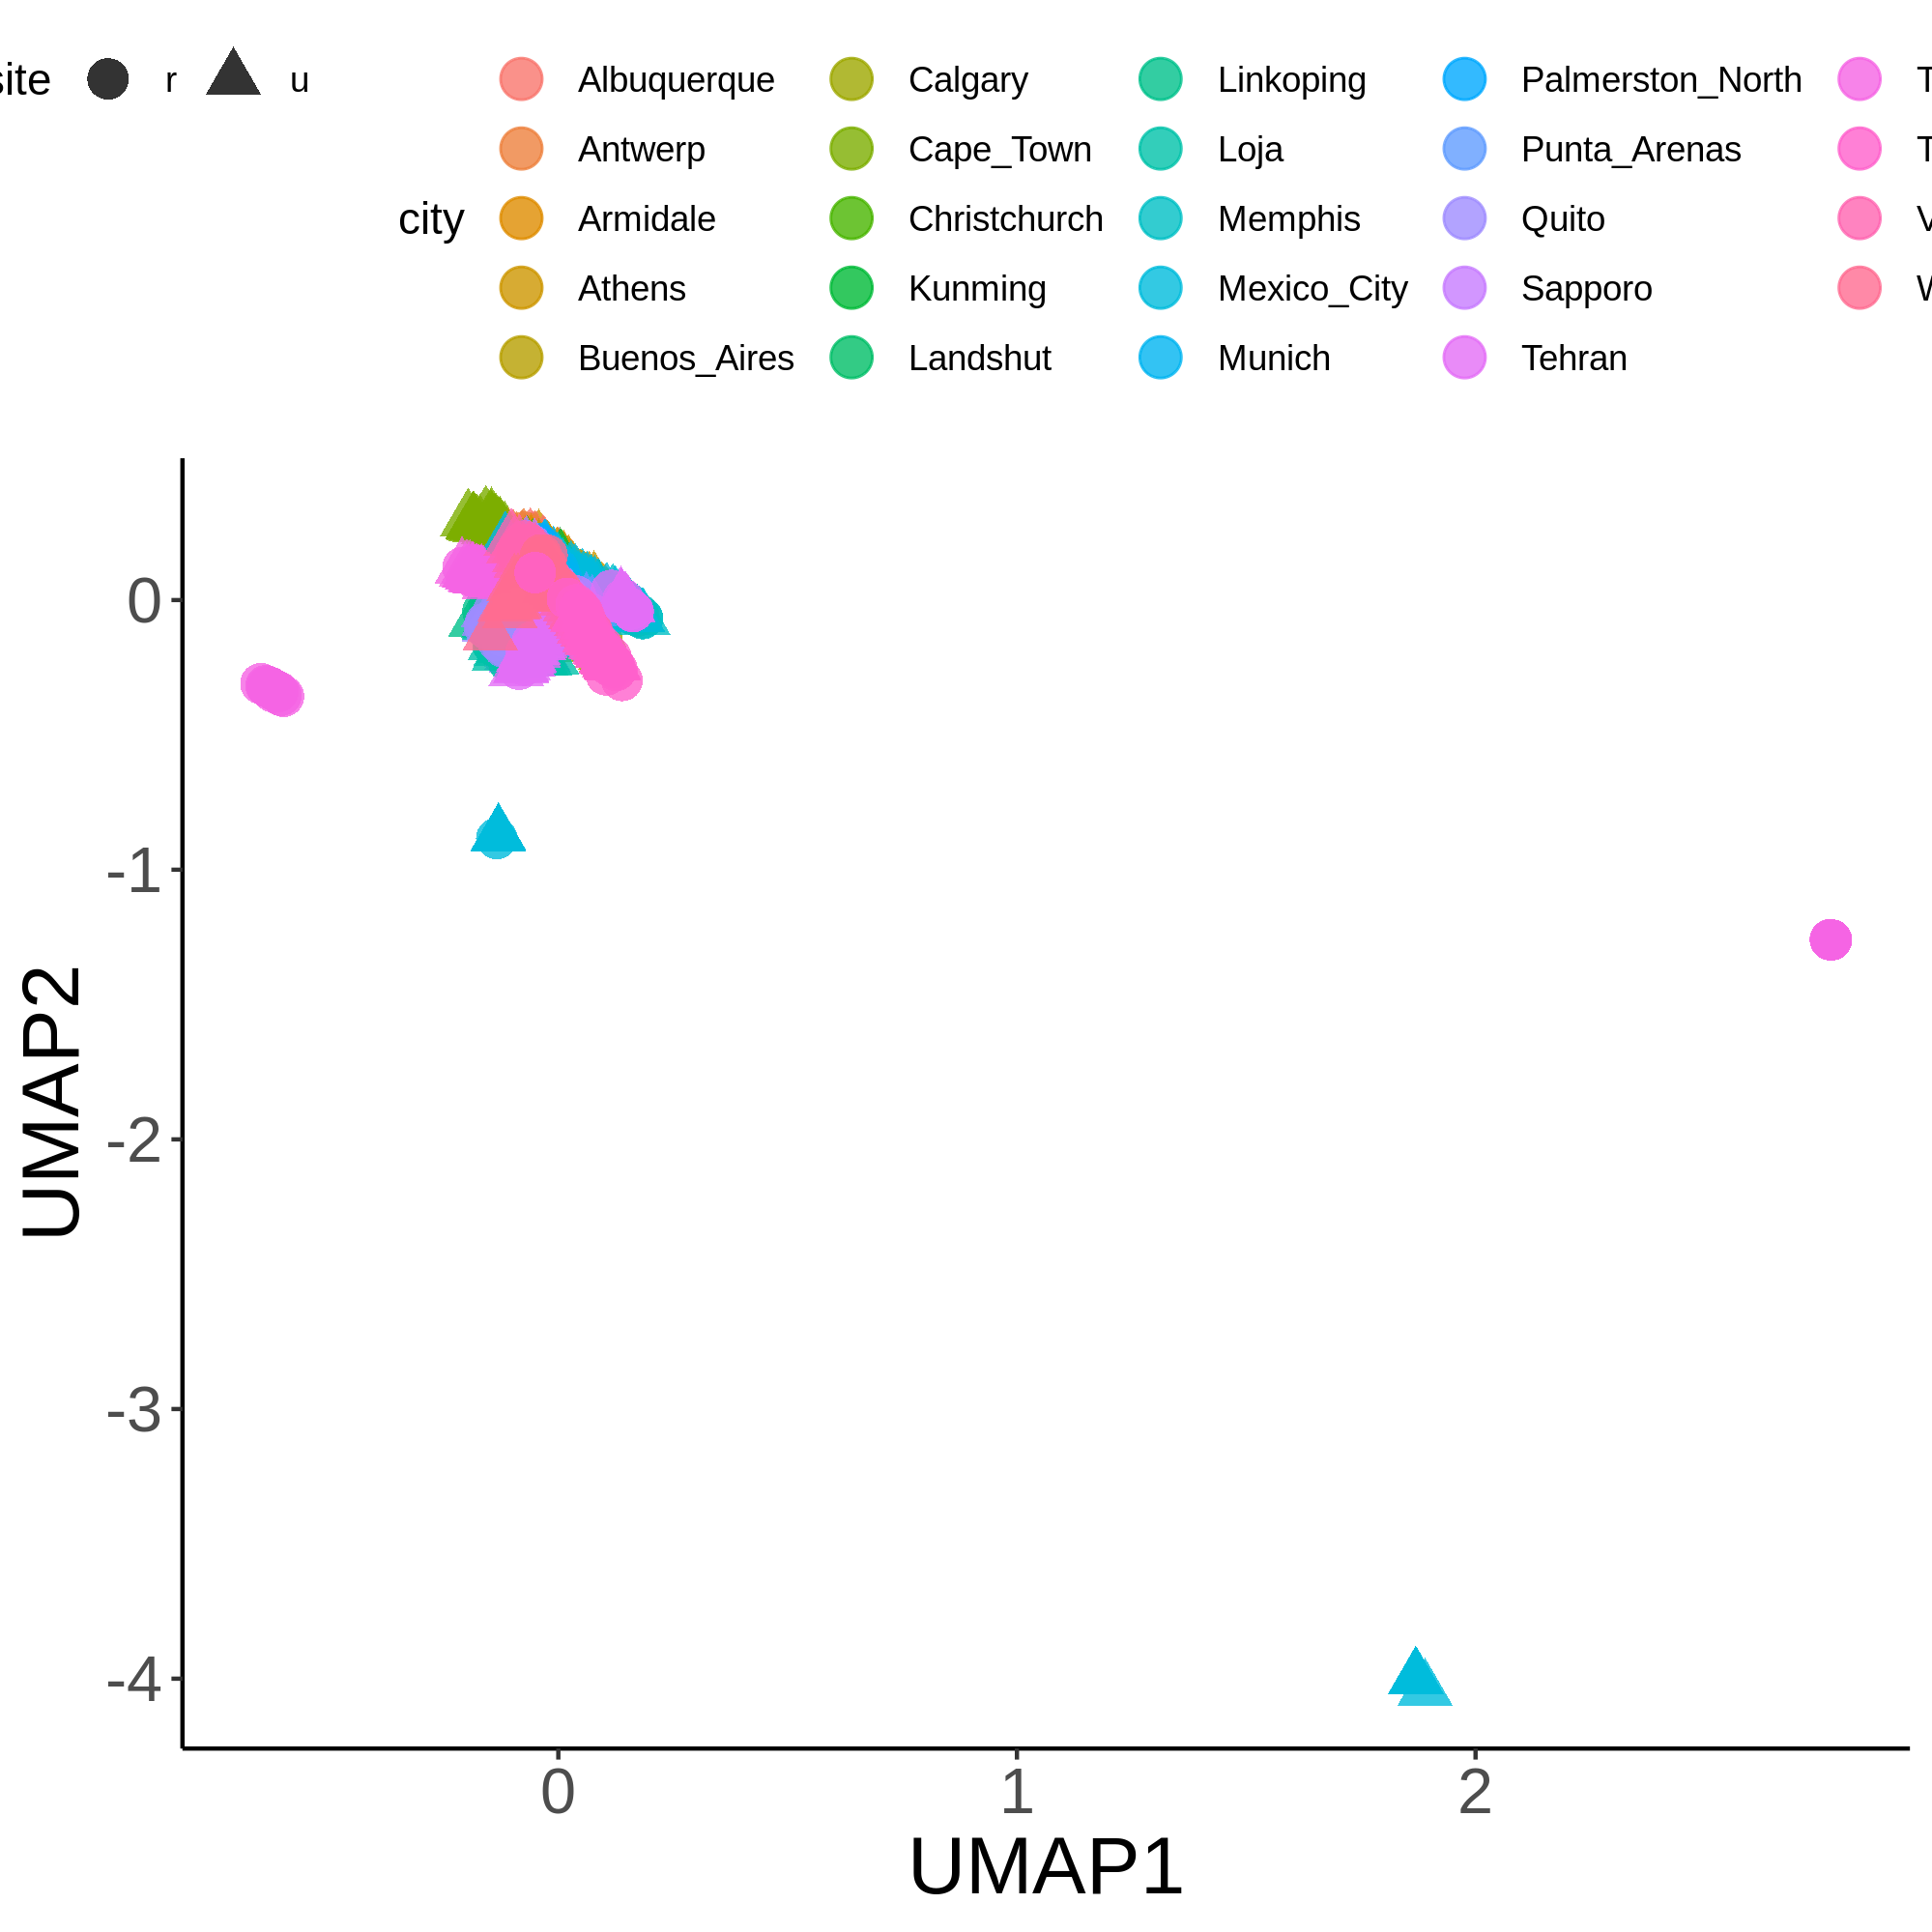

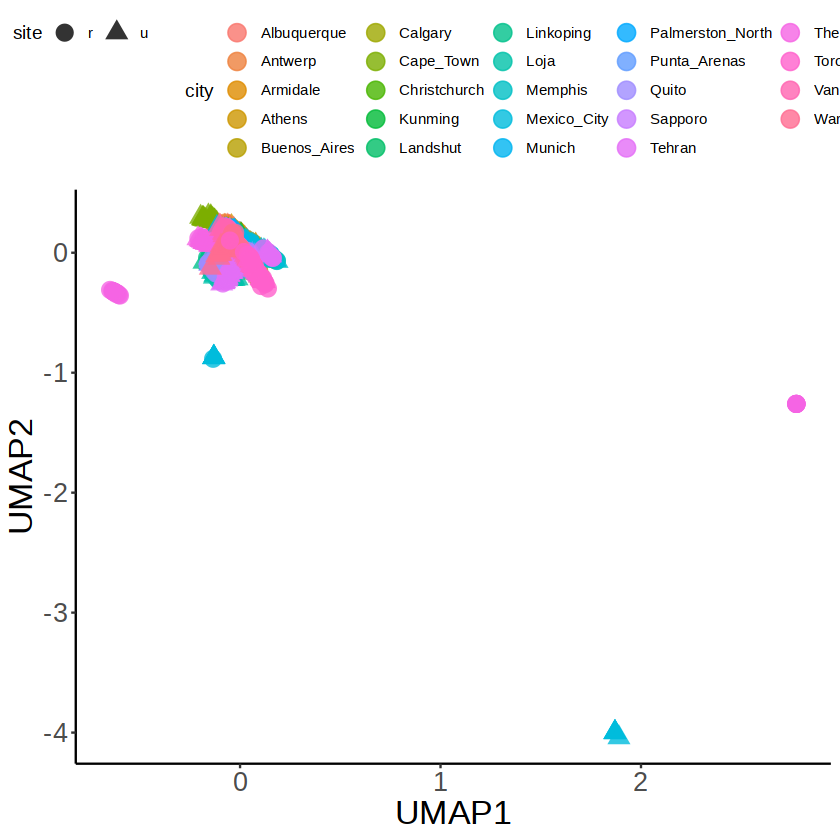

In [72]:
distMat <- as.matrix(dist(covMat))
global_umap <- umap(distMat, random_state = 42, input="dist", n_neighbors = 15, min_dist = 0.1, n_components = 40)
global_umap_layout <- global_umap$layout %>% 
    as_tibble() %>% 
    bind_cols(., global_order_detail)
umap_plot <- global_umap_layout %>%
    ggplot(., aes(x = V1, y = V2, color = city, shape = site)) +
        geom_point(size = 4.5, alpha = 0.8) +
        theme_classic() +
        xlab('UMAP1') + ylab('UMAP2') +
        theme(axis.text = element_text(size = 16),
              axis.title = element_text(size = 20),
              legend.position = 'top')
umap_plot

ggsave(
  "Global_UMAP_UMAP1_UMAP2.png",
  plot = umap_plot,
  device = png,
  path = "/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/umap",
  dpi = 300
)

path_to_kplot<-"/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/umap/Global_UMAP_UMAP1_UMAP2.png"
display_png(file=path_to_kplot)

Warning message:
“ggrepel: 9 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 5 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


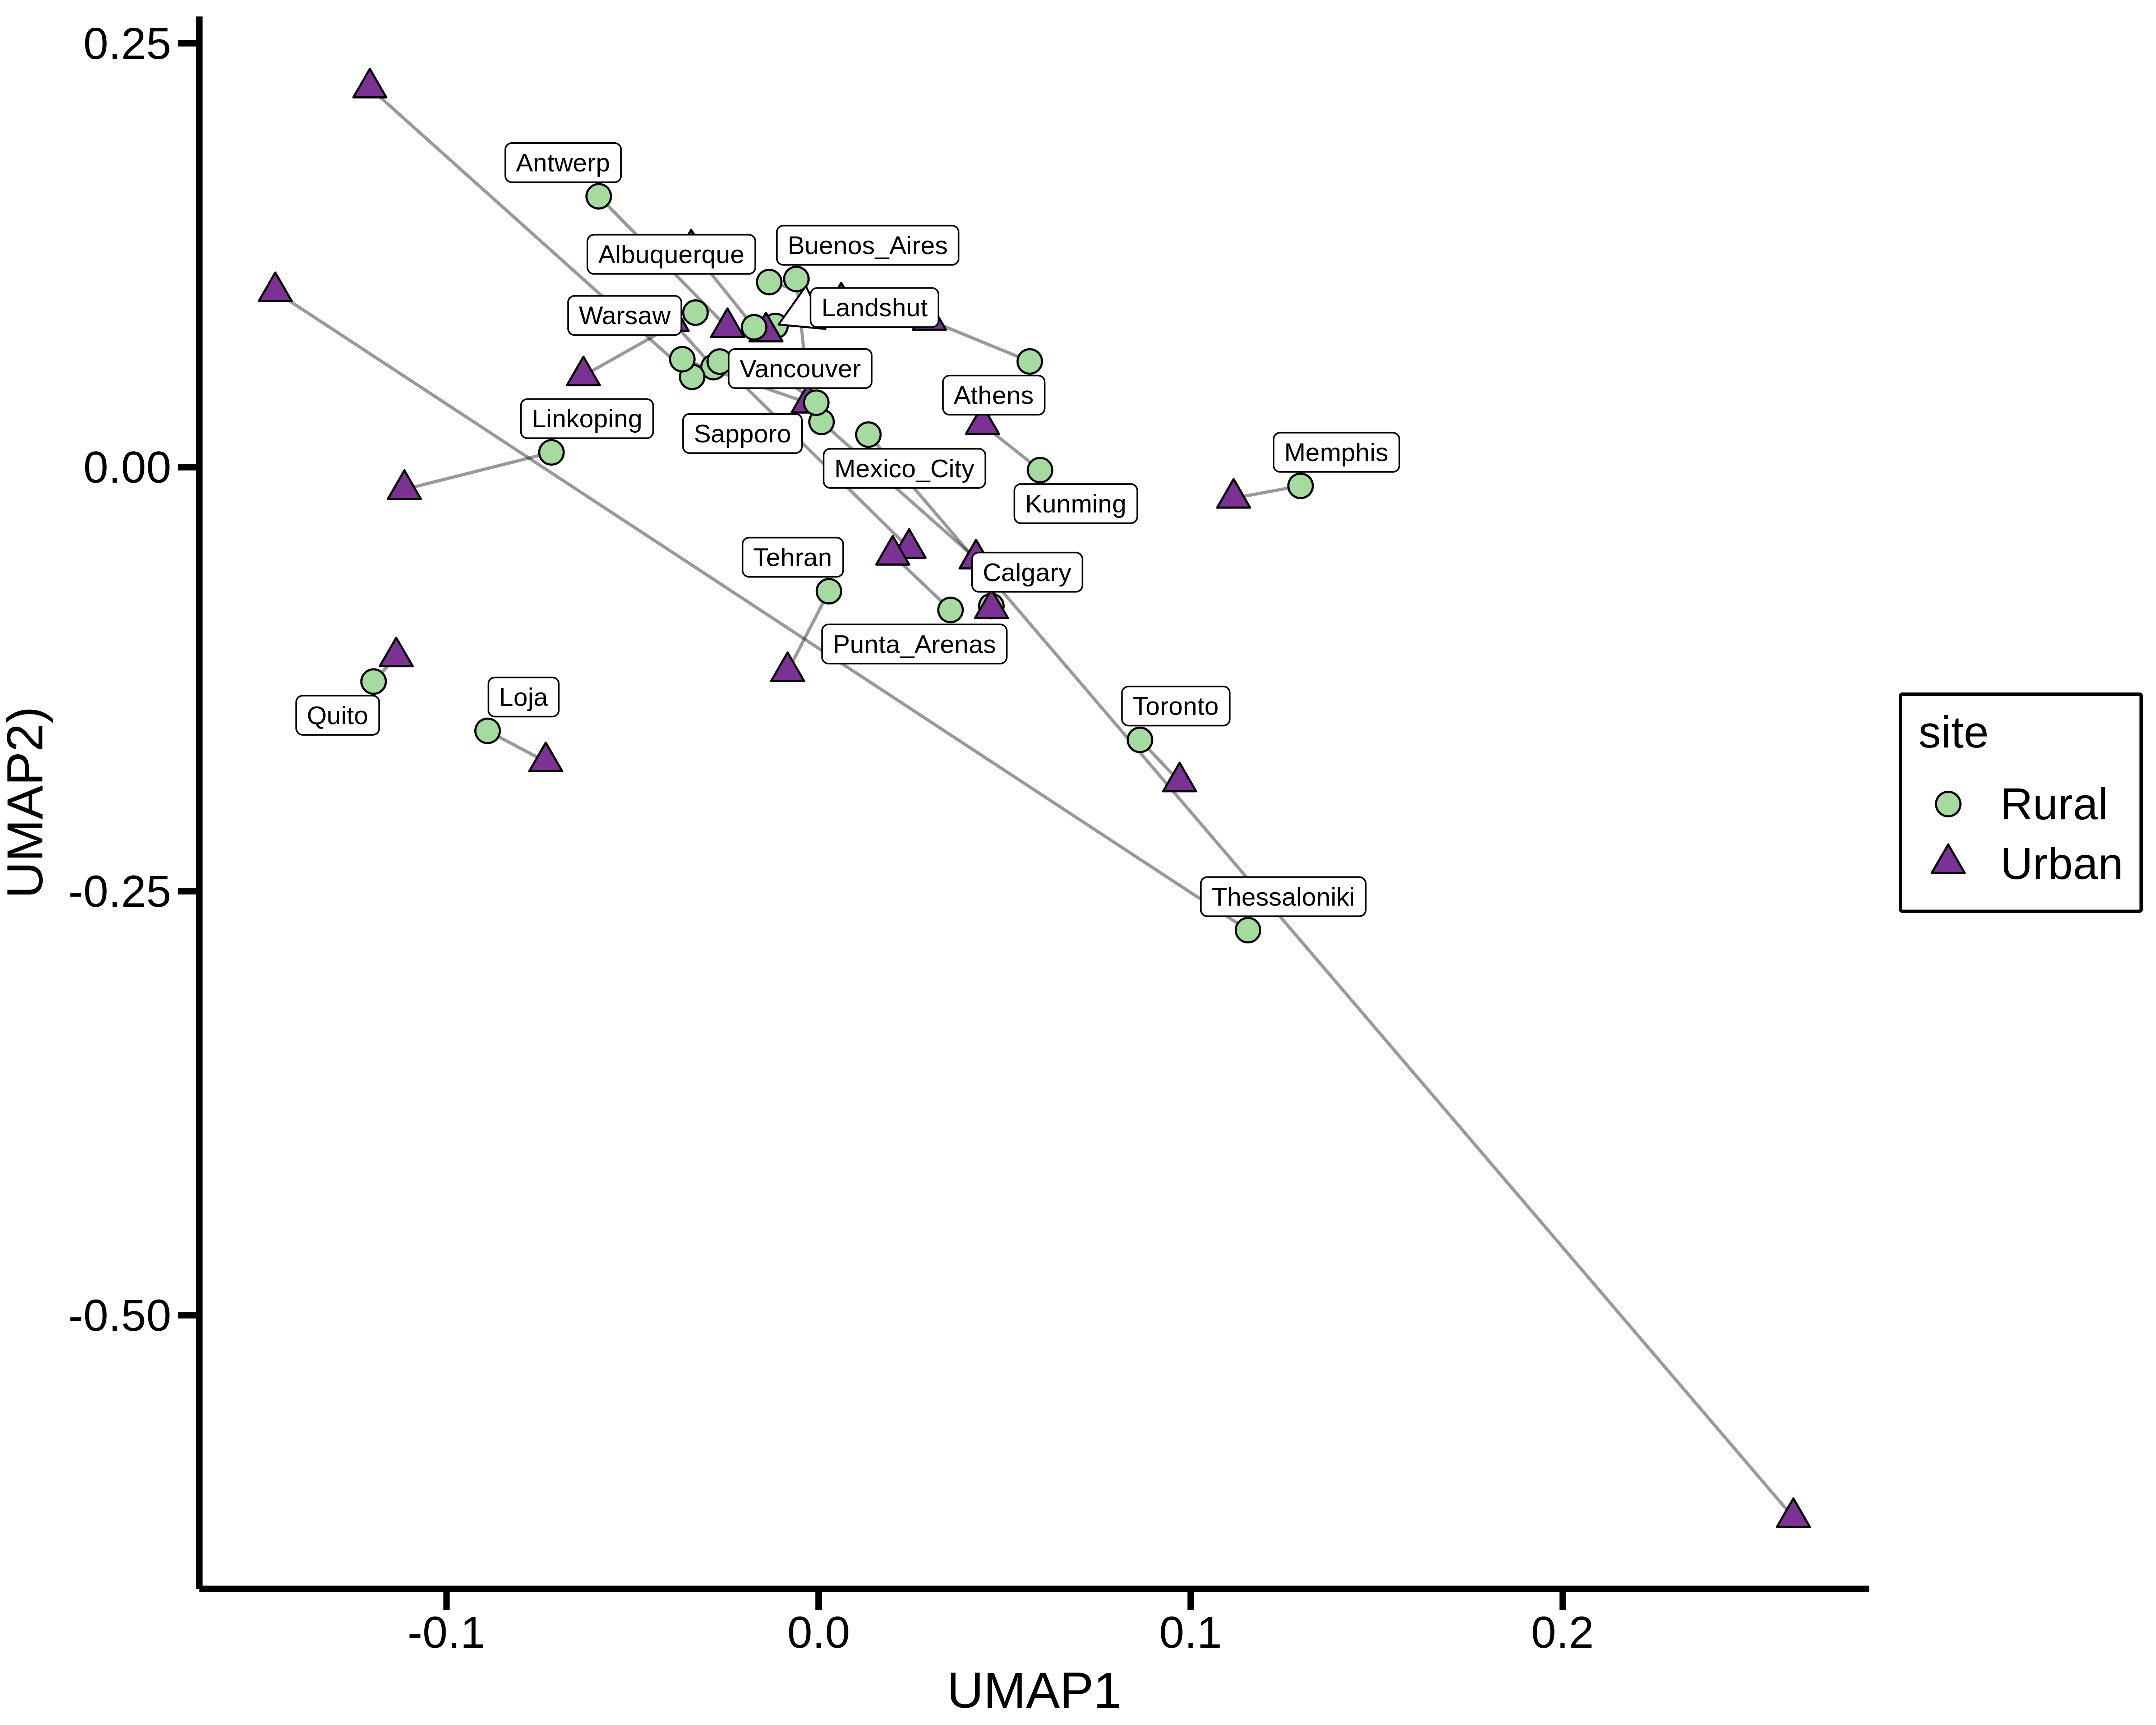

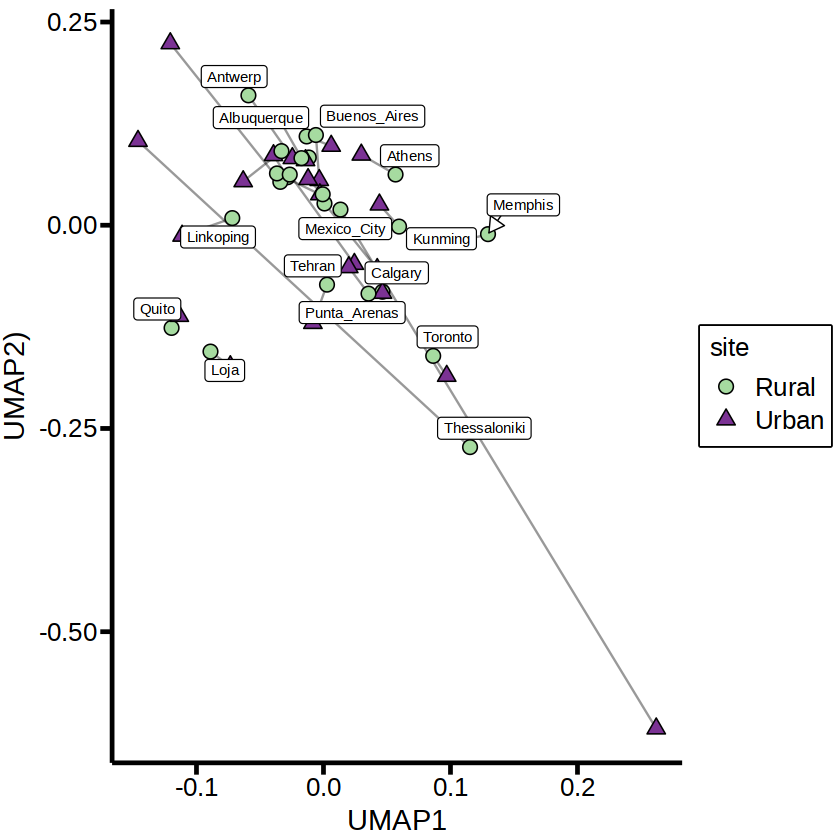

In [75]:
umap_centroids_df_forPlot <- global_umap_layout %>% 
    group_by(city, site) %>% 
    summarise(x = mean(V1),
              y = mean(V2),
             .groups = 'drop')

umap_centroids <- umap_centroids_df_forPlot %>%
    mutate(site = fct_recode(site, 'Rural' = 'r', 'Urban' = 'u')) %>%
    ggplot(., aes(x = x, y = y, fill = site, shape = site)) +
    geom_line(size = 0.5, alpha = 0.4, aes(group = city)) +
    geom_point(size = 3.5) +
    scale_fill_manual(values = rev(cols), labels = c('Rural', 'Urban')) +
    scale_shape_manual(values = c(21, 24), labels = c('Rural', 'Urban')) +
    #scale_x_continuous(breaks = seq(from = -0.08, to = 0.06, by = 0.02)) +
    #scale_y_continuous(breaks = seq(from = -0.05, to = 0.15, by = 0.03)) +
    ylab('UMAP2)') + xlab("UMAP1") + 
    geom_label_repel(data = . %>% filter(site == 'Rural'),
                     aes(label = city),
                        color = 'black',
                        fill = 'white', 
                        size = 3,
                        arrow = arrow(length = unit(0.03, "npc"), 
                        type = "closed", ends = "last"),
                        segment.size  = 0.3)+
    theme(panel.background = element_blank(),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            panel.border=element_blank(),
            axis.line.x = element_line(color="black",size=1),
            axis.line.y = element_line(color="black",size=1),
            axis.ticks=element_line(size = 1, color="black"),
            axis.ticks.length=unit(0.25, 'cm'),
            axis.text=element_text(color="black",size=15),
            axis.title=element_text(color="black",size=1),
            axis.title.y=element_text(vjust=2,size=17),
            axis.title.x=element_text(vjust=0.1,size=17),
            axis.text.x=element_text(size=15),
            axis.text.y=element_text(size=15),
            strip.text.x = element_text(size = 15, colour = "black",face = "bold"),
            strip.background = element_rect(colour="black"),
            legend.text=element_text(size=15), legend.key = element_rect(fill = "white"),
            legend.title = element_text(size=15),legend.key.size = unit(0.7, "cm"),
            legend.position = "right",
            legend.direction="vertical",
            legend.box.background = element_rect(colour = "black",size=1))

ggsave(
  "Centroid_UMAP.png",
  plot = umap_centroids,
  device = png,
  path = "/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/pca",
  width = 10, height = 8, units = 'in', dpi = 600
)
display_png(file="/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/pca/Centroid_UMAP.png")


In [198]:
# What are those outlier cluster?
global_umap_layout %>% filter((V1 > -0.2 & V2 < -0.2) | ( V1 < 0.18 & V2 > 0.2))

V1            V2         V3          V4          V5          V6          
1   -0.09536316   -0.4502377 -0.03574123  0.06145425  0.20297772  0.3478256  
2   -0.06301646   -0.5558888 -0.12443472  0.02882191  0.23754922  0.2913130  
3   -0.06806414   -0.4497867 -0.04690693  0.05212988  0.19806631  0.3682953  
4   -0.06146955   -0.5186872 -0.09756762  0.03793338  0.22302784  0.3218814  
5   -0.09617653   -0.4588752 -0.04915797  0.06481921  0.21389917  0.3435115  
6   -0.07443298   -0.5602830 -0.10170971  0.03467852  0.22814455  0.2878509  
7   -0.05355014   -0.4029363  0.06054697  0.01036010  0.10028002  0.3545853  
8   -0.07113956   -0.3801935  0.08517623  0.02074835  0.09540268  0.3611497  
9   -0.06317912   -0.4810242 -0.07906127  0.04859755  0.21573637  0.3543591  
10  -0.09974465   -0.4952682 -0.10515948  0.07437985  0.25454990  0.3350864  
11  -0.09527741   -0.3420285  0.12621643  0.02904901  0.08645862  0.3677272  
12  -0.11050370   -0.3641686  0.09020770  0.05253475  0.12189652  0.3671187  
13  -0.10139224   -0.4507500 -0.05097621  0.06912623  0.21746088  0.3514414  
14  -0.07138872   -0.5421212 -0.13210668  0.04535992  0.25306233  0.3049475  
15  -0.06824836   -0.5343975 -0.15778726  0.06519565  0.28053911  0.3246569  
16  -0.11840795   -0.5125375 -0.10798955  0.08336149  0.26689390  0.3155530  
17  -0.10344337   -0.5025200 -0.12857656  0.08345308  0.27806463  0.3281925  
18  -0.07805784   -0.5206540 -0.15424063  0.07002894  0.28643083  0.3206402  
19  -0.09275930   -0.4891040 -0.11043538  0.07782742  0.25756660  0.3490013  
20  -0.06979644   -0.4769805 -0.08896174  0.06001560  0.22851179  0.3636808  
21   0.11616310   -0.2154356  0.18117189  0.28423824 -0.05272489  0.2316777  
22   0.10607490   -0.2025977  0.15968432  0.31930124 -0.05631697  0.2380317  
23   0.11174773   -0.2046858  0.16825298  0.28511612 -0.05574944  0.2275324  
24   0.10437392   -0.2086657  0.17006865  0.32415159 -0.08318334  0.2634072  
25   0.10079365   -0.2065910  0.16813057  0.32097331 -0.08458280  0.2610310  
26   0.21004351   -0.2223516  0.23250362 -2.59413671  1.14257274 -2.9944885  
27   0.20989948   -0.2223375  0.23245540 -2.59121731  1.14127083 -2.9911530  
28  -0.01197190   -0.5073209 -0.07167179 -0.01308438  0.17644415  0.3144200  
29  -0.06467207   -0.4284466  0.02008226  0.02514518  0.13798058  0.3511011  
30  -0.04775251   -0.5283673 -0.07370873  0.01267192  0.19124094  0.3040047  
⋮   ⋮             ⋮          ⋮           ⋮           ⋮           ⋮           
187 -7.921295e-03 -0.2032038 0.06808693  0.1271157   0.10963935  -0.001462692
188  1.034280e-02 -0.2191459 0.08723144  0.1190192   0.08976589  -0.032804645
189  2.922030e-02 -0.2205576 0.10087848  0.1404189   0.07593689  -0.020254692
190  2.619895e-02 -0.2070067 0.09678953  0.1273681   0.06403417  -0.030516397
191 -5.612923e-03 -0.2061113 0.07186619  0.1186657   0.09878720  -0.024612616
192  1.735268e-02 -0.2346200 0.09753647  0.1323170   0.09871554  -0.016954312
193  1.406860e-02 -0.2138095 0.08838975  0.1074219   0.08910305  -0.033358045
194  1.017195e-03 -0.2325569 0.09314207  0.1227362   0.06845650  -0.055017318
195  3.623399e-03 -0.2308811 0.09373247  0.1227972   0.07068355  -0.050631690
196  3.425508e-03 -0.2313937 0.09367248  0.1206139   0.06964346  -0.054241956
197 -2.257877e-03 -0.2318074 0.09138847  0.1210343   0.07004777  -0.053271377
198  7.428951e-03 -0.2226946 0.08962434  0.1193707   0.07728447  -0.045320833
199 -3.213414e-03 -0.2355477 0.09349472  0.1243849   0.06468779  -0.056987174
200 -6.245428e-03 -0.2126399 0.07476983  0.1305261   0.09736672  -0.017559854
201  4.016038e-06 -0.2130774 0.07813708  0.1336067   0.09721109  -0.014832728
202  8.476324e-04 -0.2147402 0.07937929  0.1216126   0.09455542  -0.028582255
203  2.052534e-03 -0.2061878 0.07589159  0.1316201   0.10505573  -0.001681339
204  2.049114e-03 -0.2122855 0.07933395  0.1179121   0.09047031  -0.034204628
205  2.169196e-02 -0.2041449 0.08838102  0.1044763   0.08550469  -0.034340683
206  1.459995e-02 -0.22246

# PCA and UMAP by city

## Figure automatization 

### PCA

In [7]:
# File of samples order per city
list<-c("Albuquerque", "Antwerp", "Armidale","Athens","Buenos_Aires",
        "Calgary","Cape_Town","Christchurch","Kunming","Landshut","Linkoping","Loja","Memphis",
        "Mexico_City","Munich","Palmerston_North","Punta_Arenas","Quito","Sapporo","Tehran",
        "Thessaloniki","Toronto","Vancouver","Warsaw")
samples<-read.csv("/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/resources/glue_noLowCities_sampleSheet_noRelated.txt", header=TRUE, sep="\t")

for (city in list){
    samples<-read.csv("/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/resources/glue_noLowCities_sampleSheet_noRelated.txt", header=TRUE, sep="\t")
    detail <- read.table(paste0("/scratch/projects/trifolium/glue/demography/glue_demography/results/program_resources/bam_lists/by_city/withoutRelated/",city,"/",city,"_4fold_lowCovRemoved_bams.list"))
    head(detail)
    detail$V1<-gsub("/scratch/projects/trifolium/glue/pc/results/bam/4fold/","",as.character(detail$V1))
    detail$V1<-gsub("_4fold.bam","",as.character(detail$V1))
    name <-paste0(city,'_order_detail')
    tmp <-merge(samples, detail,  by.x="sample", by.y="V1", all.x=FALSE, all.y=TRUE, sort=FALSE) 
    assign(name,tmp)
    }

  overlap 
0.1299369 
  overlap 
0.1979634 
  overlap 
0.3439625 
  overlap 
0.6019042 
  overlap 
0.4025103 
  overlap 
0.3980147 
 overlap 
0.322865 
  overlap 
0.2175994 
  overlap 
0.5064255 
  overlap 
0.4140127 
  overlap 
0.1961763 
  overlap 
0.6886937 
   overlap 
0.01392517 
  overlap 
0.2104096 
  overlap 
0.2115942 
   overlap 
0.09106871 
   overlap 
0.03027818 
  overlap 
0.3491076 
   overlap 
0.05349127 
  overlap 
0.4910015 
  overlap 
0.3682986 
  overlap 
0.1346163 
 overlap 
0.149253 
  overlap 
0.5024078 


Warning message in MASS::cov.trob(data[, vars]):
“Probable convergence failure”


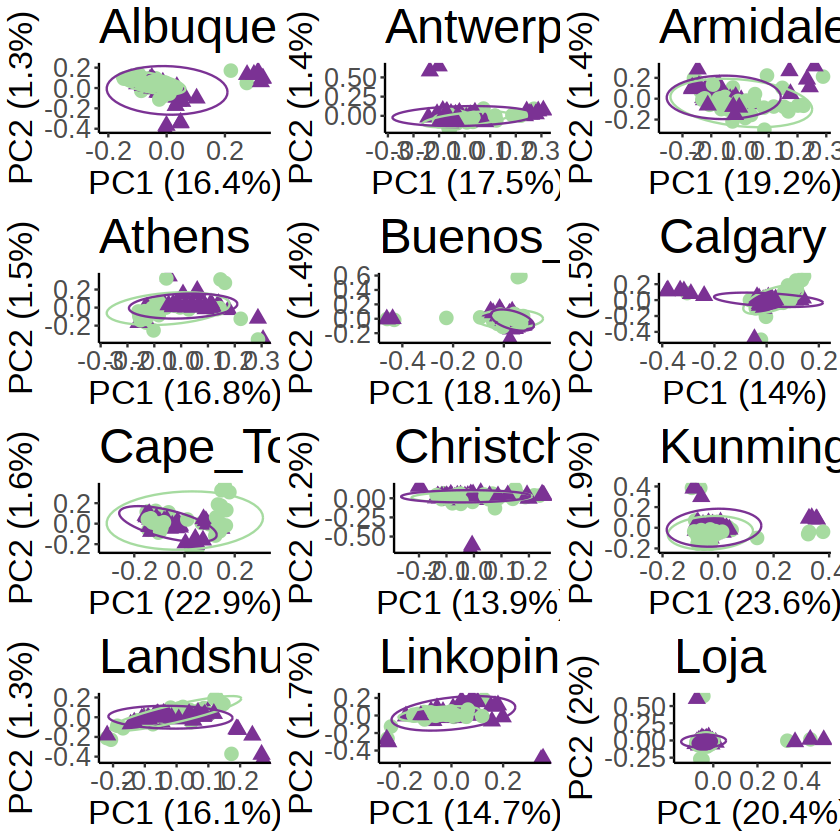

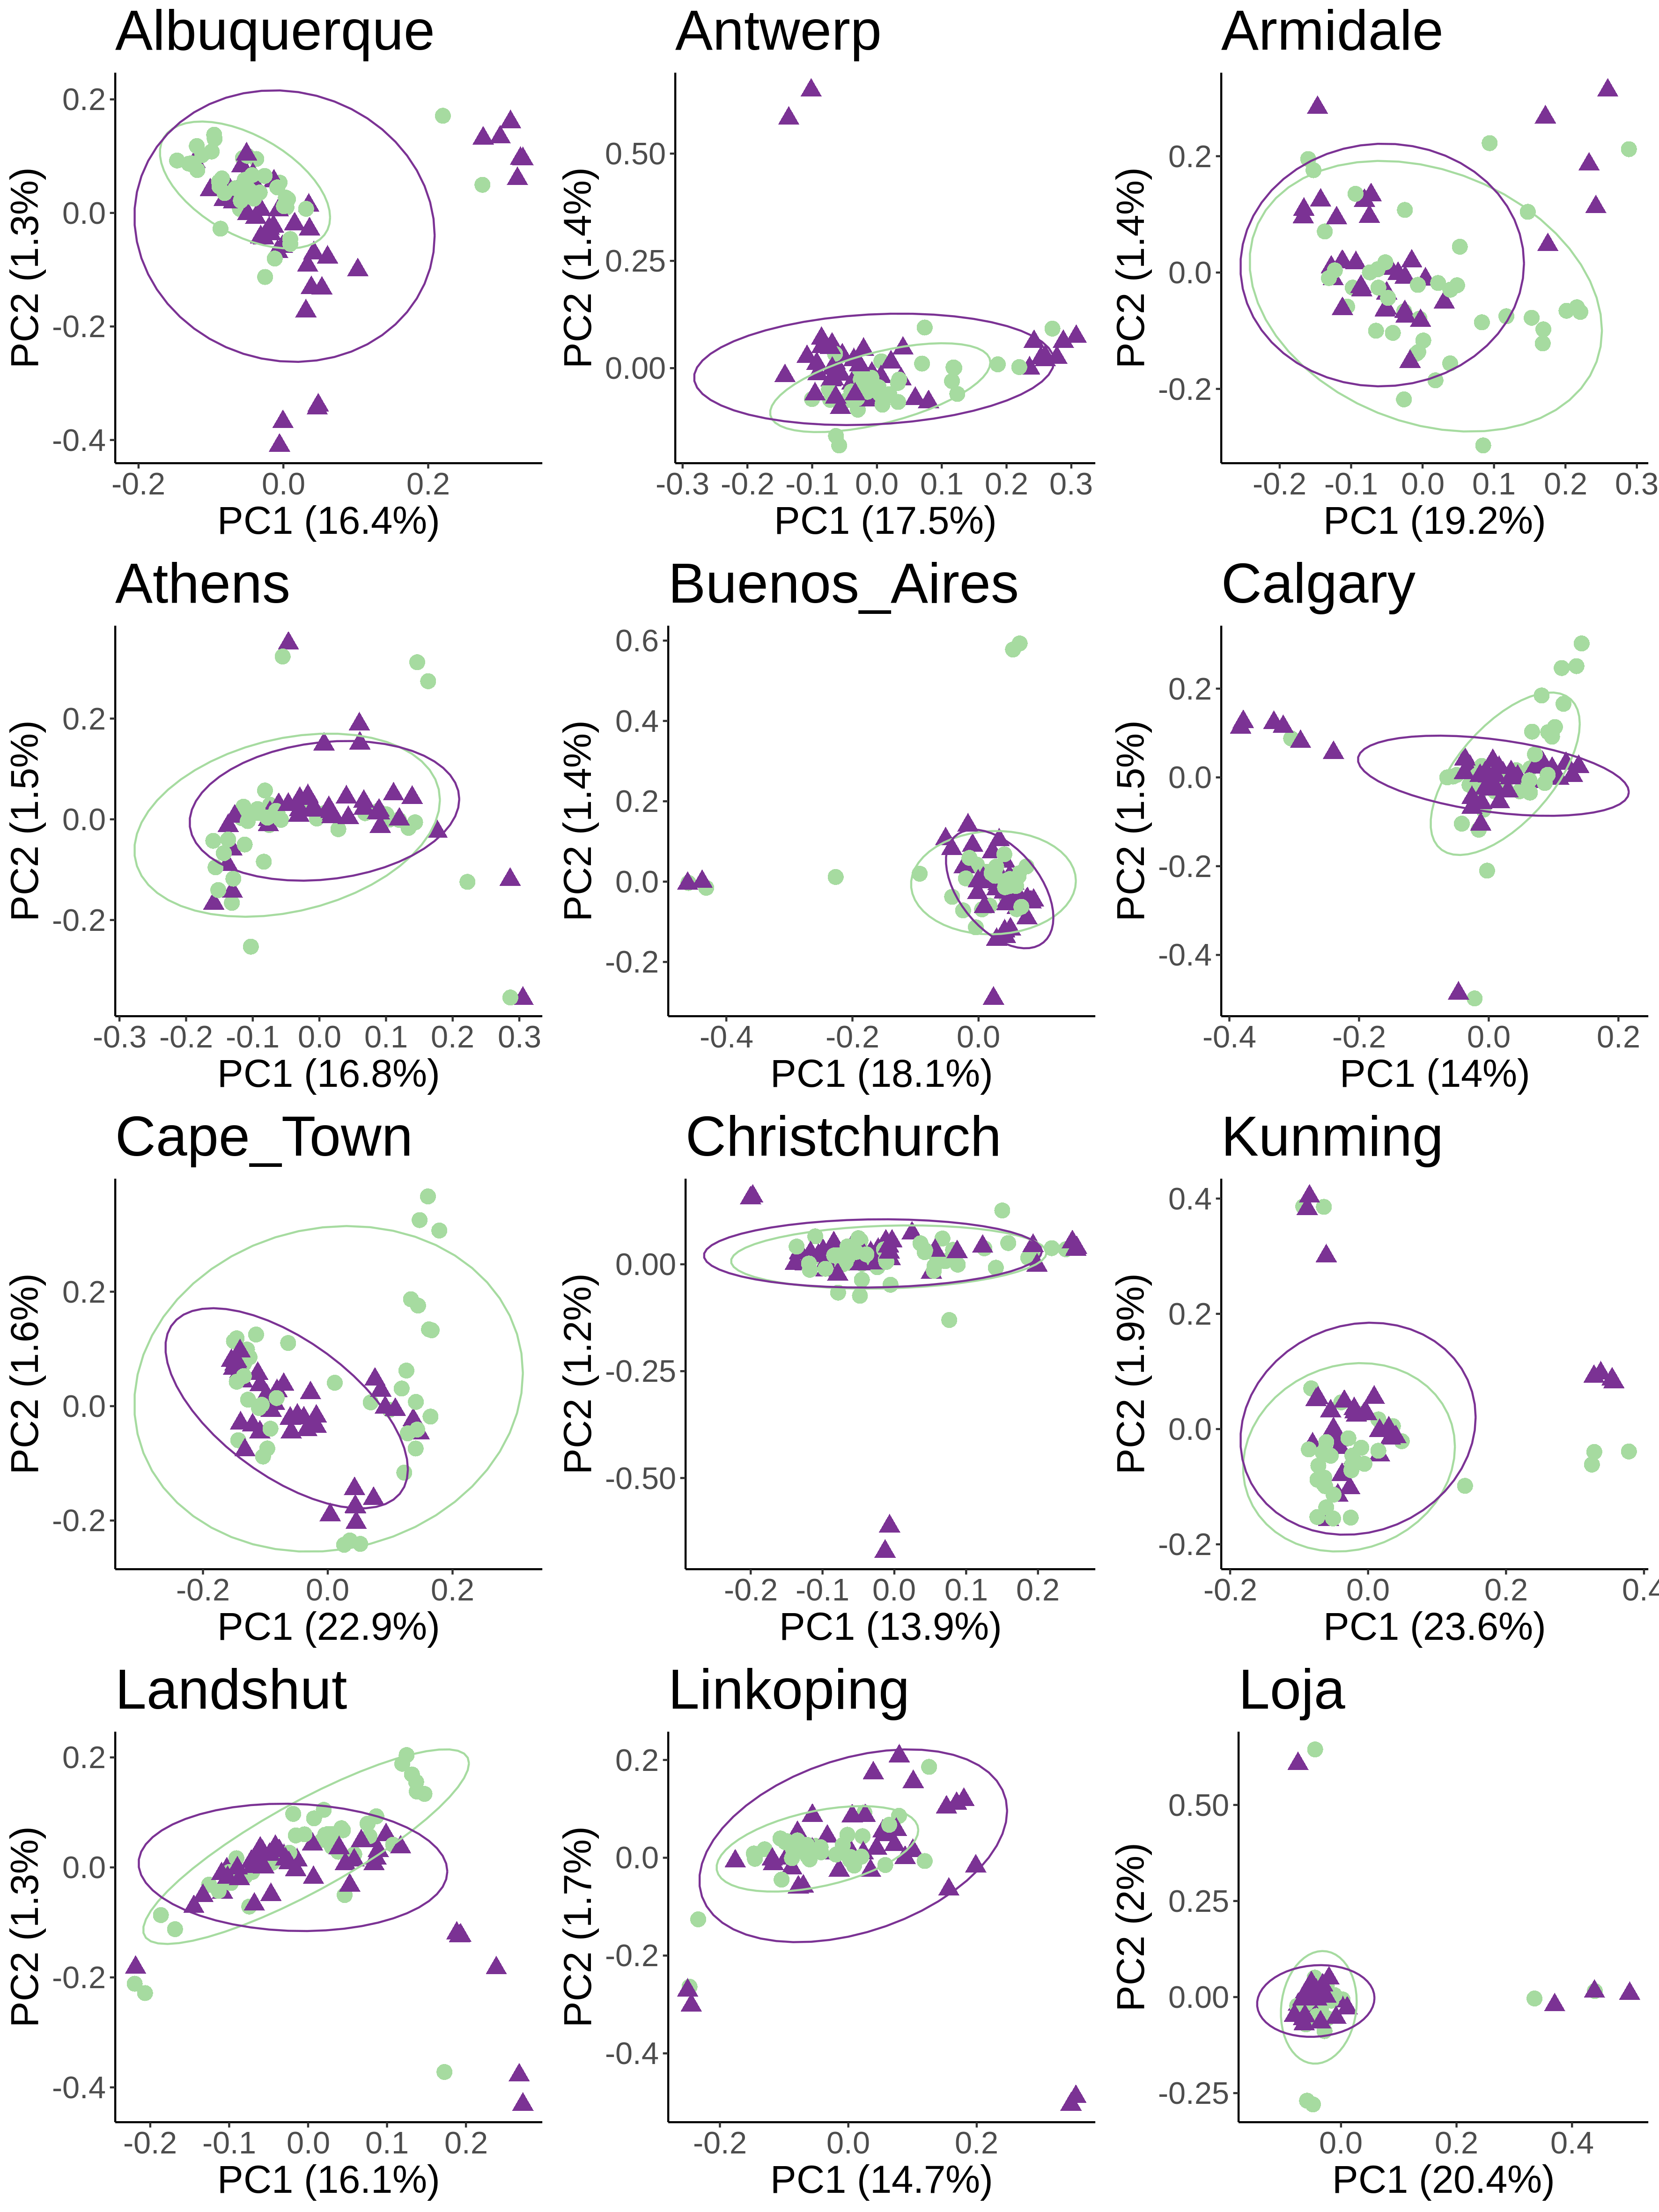

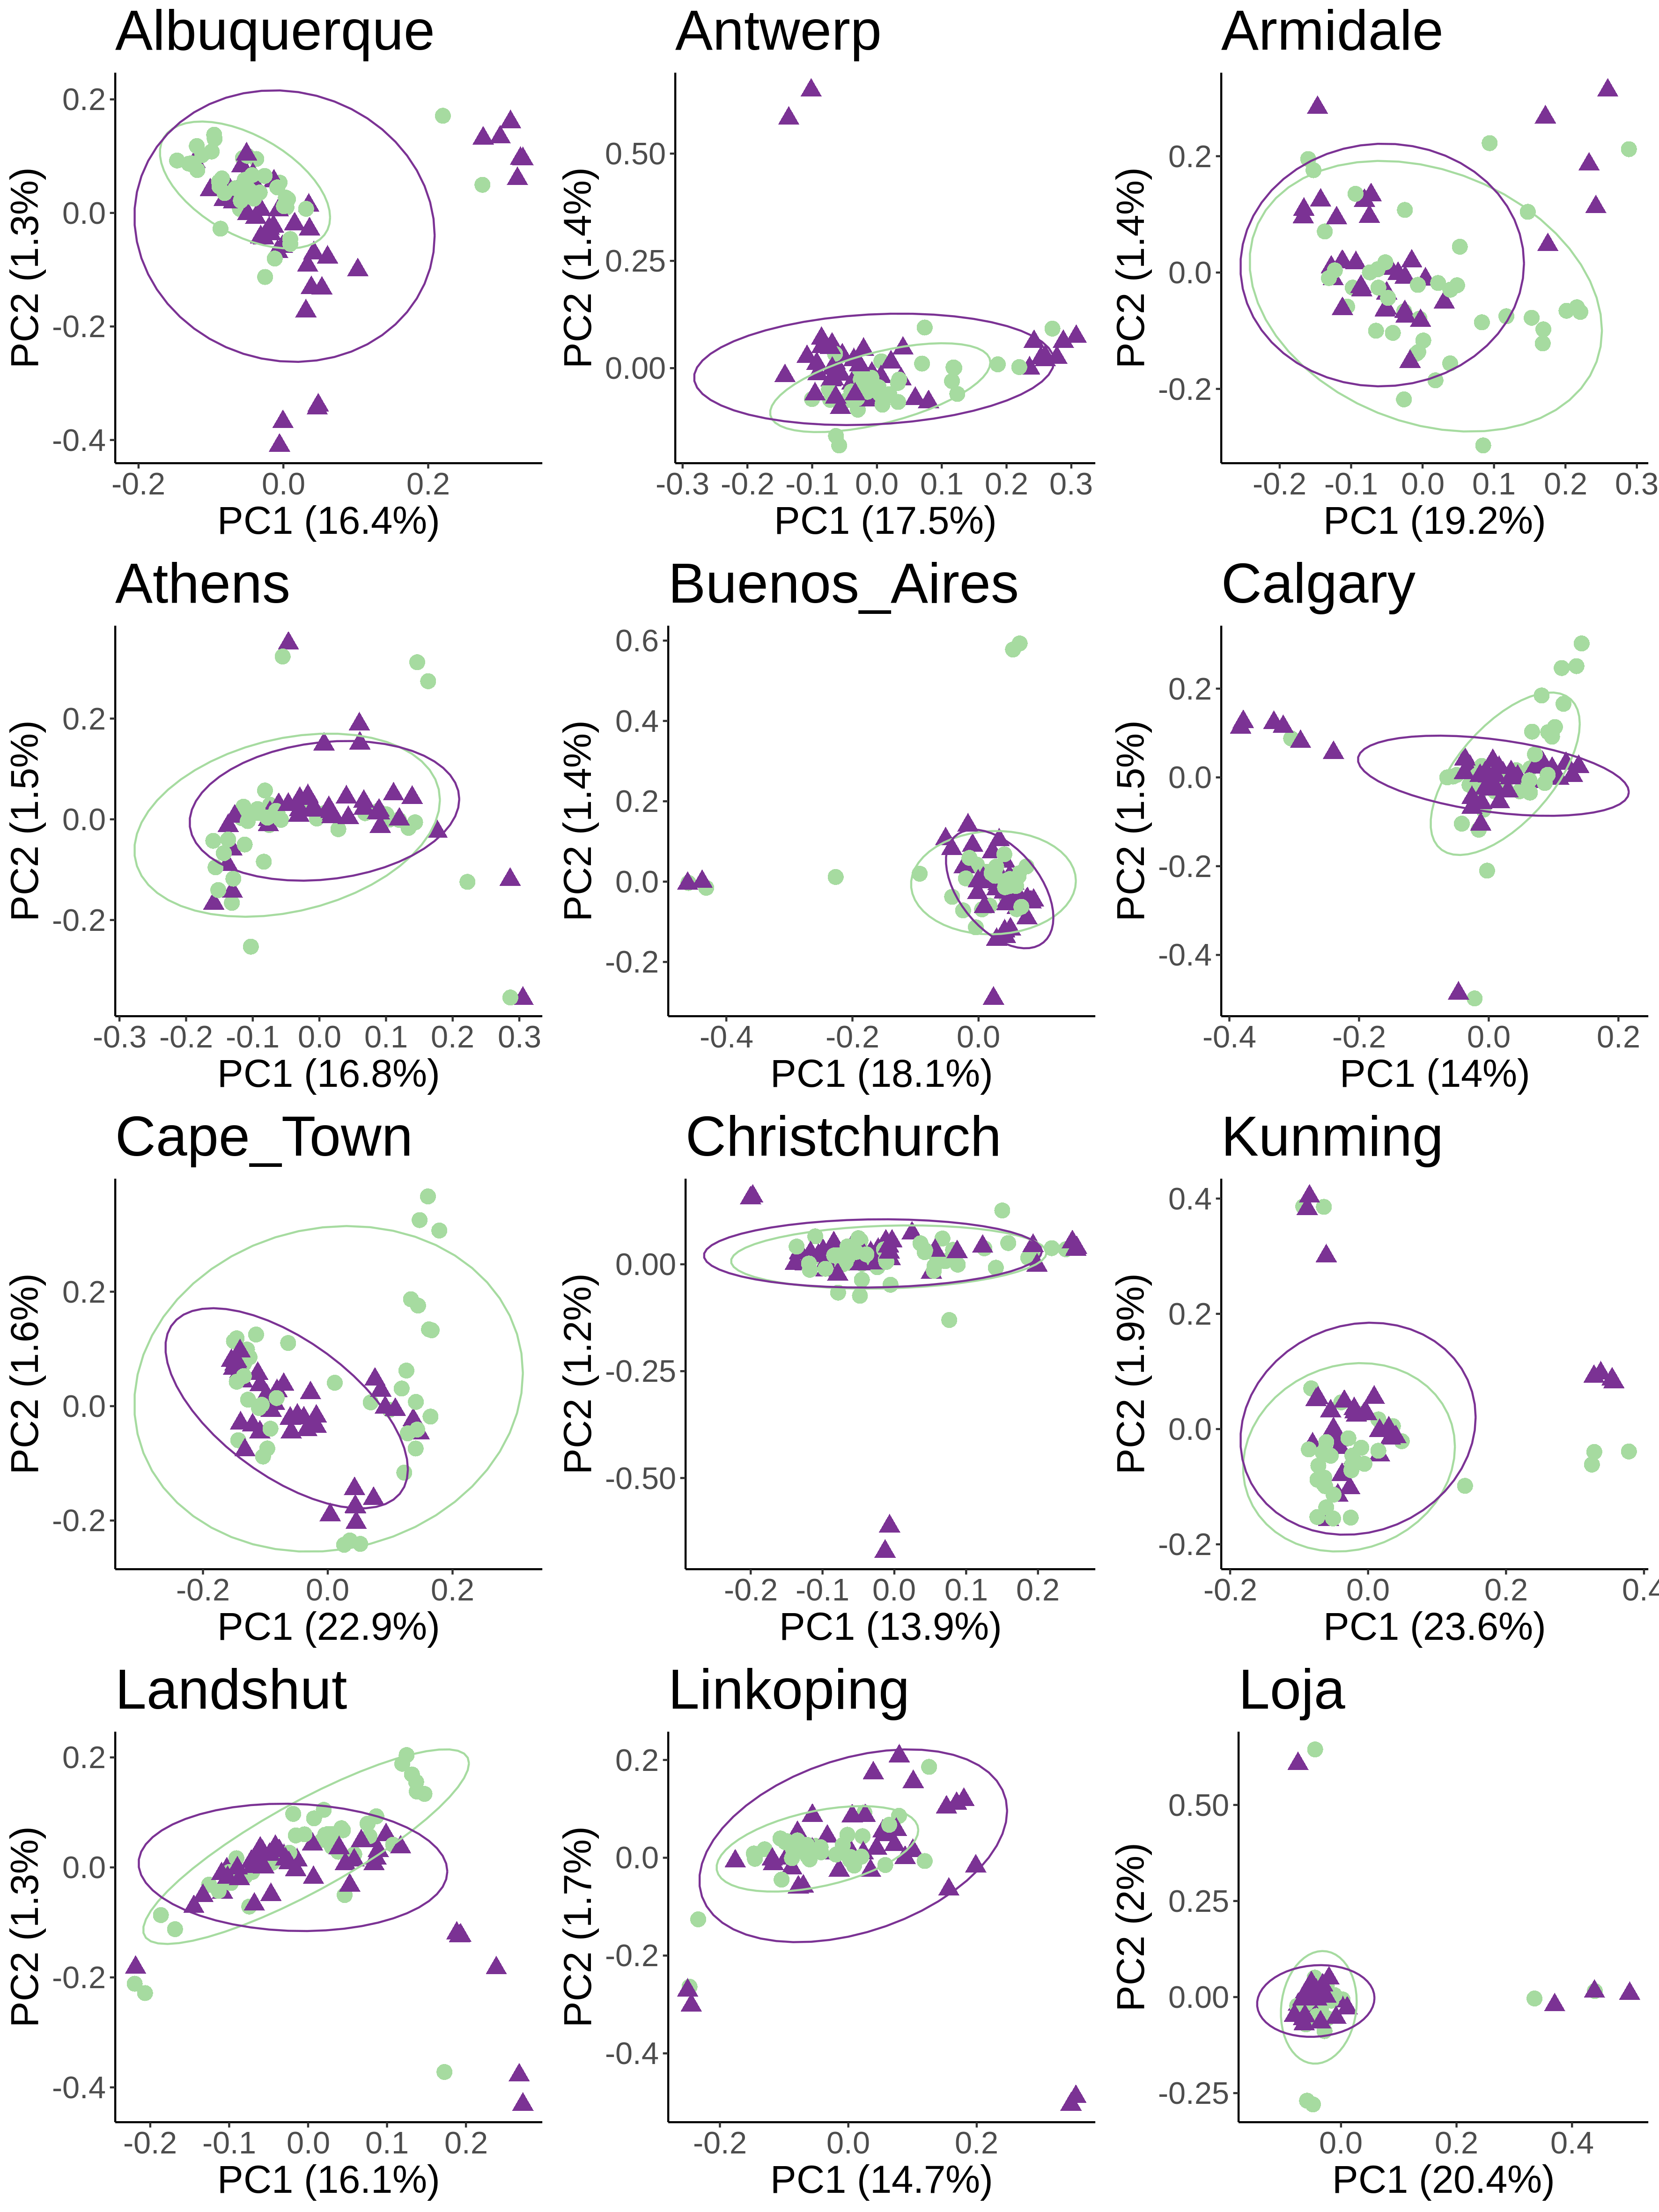

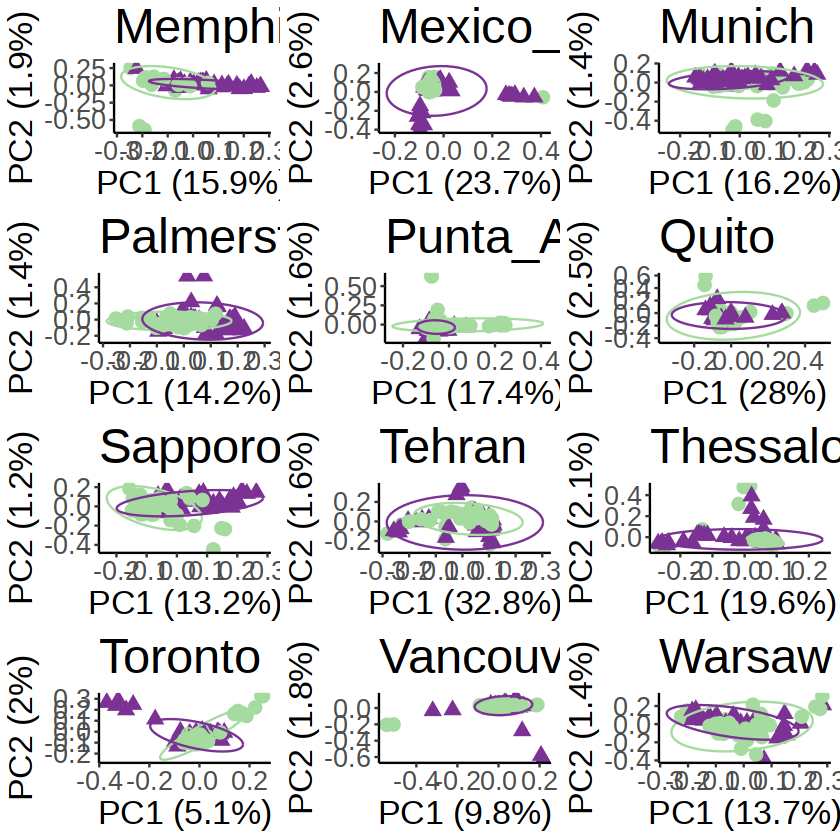

In [18]:
list<-c("Albuquerque", "Antwerp", "Armidale","Athens","Buenos_Aires",
        "Calgary","Cape_Town","Christchurch","Kunming","Landshut","Linkoping","Loja","Memphis",
        "Mexico_City","Munich","Palmerston_North","Punta_Arenas","Quito","Sapporo","Tehran",
        "Thessaloniki","Toronto","Vancouver","Warsaw")

columns<- c("city","habitat","area","var_explained1","var_explained2","continent","range") 
table_area<- data.frame(matrix(nrow = 0, ncol = length(columns))) 
colnames(table_area) = columns

columns2<- c("city","overlap","var_explained1","var_explained2","continent","range") 
table_overlap<- data.frame(matrix(nrow = 0, ncol = length(columns2))) 
colnames(table_overlap) = columns2

for (city in list){
    covMat<-as.matrix(read.table(paste0("/scratch/projects/trifolium/glue/demography/glue_demography/results/population_structure/pcangsd/by_city/pcangsd_withoutRelated/",city,"/",city,"_4fold_maf0.05_pcangsd.cov")))
    # Perform eigen decomposition of covariance matrix
    # Extract eigenvectors and bind with sample sheet for plotting and coloring by habitat
    eigenvectors <- eigen(covMat)
    eigen_df <- eigenvectors$vectors %>%
            as.data.frame() %>%
            dplyr::select(V1, V2, V3, V4) %>%
            rename('PC1' = 'V1',
                   'PC2' = 'V2',
                   'PC3' = 'V3',
                   'PC4' = 'V4') %>%
        bind_cols(.,get(paste0(city,'_order_detail')))
    
    eigen_df <- eigenvectors$vectors %>%
            as.data.frame() %>%
            dplyr::select(V1, V2, V3, V4) %>%
            rename('PC1' = 'V1',
                   'PC2' = 'V2',
                   'PC3' = 'V3',
                   'PC4' = 'V4') %>%
        bind_cols(.,get(paste0(city,'_order_detail')))

    # Percent Variance explained by first 4 PCs
    summary_pca<-pca_importance(summary(princomp(covMat))) %>% 
        as.data.frame() %>% 
        rownames_to_column('var') %>% 
        dplyr::select(var, Comp.1:Comp.8)
    #screeplot(princomp(covMat), bstick = TRUE, npcs=41)
    
    # PCA plot with automated axes names and title change 
    pca_plot1 <- eigen_df %>%
        ggplot(., aes(x = PC1, y = PC2, color = site, shape = site)) +
            geom_point(size = 3.5) +
            theme_classic() +
            stat_ellipse() +
            scale_color_manual(values=c("#a6dba0", "#7b3294")) +
            ggtitle(paste0(city))+
            xlab(paste0('PC1 (',round(100*summary_pca[2,2],1),'%)')) + ylab(paste0('PC2 (',round(100*summary_pca[2,3],1),'%)')) +
            theme(axis.text = element_text(size = 16),
                  axis.title = element_text(size = 20),
                  title = element_text(size=24),
                  legend.position = 'none')
    #print(pca_plot1)
    name <-paste0(city,'_plot')
    assign(name,pca_plot1)
    
    # Ellipse area and overlap
    eigen_df2<-eigen_df[,c(1,2,10,7)]
    colnames(eigen_df2)<-c("iso1", "iso2", "group", "community")
    siber_data<-createSiberObject(eigen_df2)
    group.ellipses.args  <- list(n = 100, p.interval = NULL, lty = 1, lwd = 2)
    ellipse1 <- paste0(city,".r")
    ellipse2 <- paste0(city,".u")
    areas <- maxLikOverlap(ellipse1, ellipse2, siber_data, 
                             p.interval = NULL, n = 100)
    prop.95.over <- areas[3] / (areas[2] + areas[1] -areas[3])
    print(prop.95.over)
    
    table_area[nrow(table_area) + 1,] = c(city,"r",areas[1],summary_pca[2,2],summary_pca[2,3],get(paste0(city,'_order_detail'))[1,2],get(paste0(city,'_order_detail'))[1,7])
    table_area[nrow(table_area) + 1,] = c(city,"u",areas[2],summary_pca[2,2],summary_pca[2,3],get(paste0(city,'_order_detail'))[1,2],get(paste0(city,'_order_detail'))[1,7])
    #print(table_area)
    table_overlap[nrow(table_overlap) + 1,] = c(city,prop.95.over,summary_pca[2,2],summary_pca[2,3],get(paste0(city,'_order_detail'))[1,2],get(paste0(city,'_order_detail'))[1,7])
    #print(table_overlap)
    
    #ggsave(
    #  filename=paste0(city,"_PCA.png"),
    #  plot = pca_plot1,
    #  device = png,
    #  path = "/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/pca",
    #  dpi = 300
    #)
    }

#write_csv(table_area, '../analyses/tables/pca_ellipse_areas.csv')
#write_csv(table_overlap, '../analyses/tables/pca_ellipse_overlap.csv')

pca_combined1<-ggarrange(Albuquerque_plot,Antwerp_plot,Armidale_plot,Athens_plot,
                       Buenos_Aires_plot,Calgary_plot,Cape_Town_plot,Christchurch_plot,
                       Kunming_plot,Landshut_plot,Linkoping_plot,Loja_plot,
                       ncol=3,nrow=4)
pca_combined1

pca_combined2<-ggarrange(Memphis_plot,Mexico_City_plot,Munich_plot,Palmerston_North_plot,
                       Punta_Arenas_plot,Quito_plot,Sapporo_plot,Tehran_plot,
                       Thessaloniki_plot,Toronto_plot,Vancouver_plot,Warsaw_plot,
                       ncol=3,nrow=4)
pca_combined2

ggsave(
    "pca_pannel1.png",
    plot= pca_combined1,
    device = png,
    path = "/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/pca",
    width = 30,
    height = 40,
    units = "cm",
    dpi = 300
    )
path_to_pca1<-"/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/pca/pca_pannel1.png"
display_png(file=path_to_pca1)

ggsave(
    "pca_pannel2.png",
    plot= pca_combined1,
    device = png,
    path = "/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/pca",
    width = 30,
    height = 40,
    units = "cm",
    dpi = 300
    )
path_to_pca1<-"/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/pca/pca_pannel2.png"
display_png(file=path_to_pca1)


### UMAP

In [19]:
for (city in list){
    distMat <- as.matrix(dist(covMat))
    object_umap <- umap(distMat, random_state = 42, input="dist", n_neighbors = 15, min_dist = 0.1, n_components = 40)
    object_umap_layout <- object_umap$layout %>% 
        as_tibble() %>% 
        bind_cols(., get(paste0(city,'_order_detail')))
    
    umap_plot <- object_umap_layout %>%
        ggplot(., aes(x = V1, y = V2, color = site, shape = site)) +
            geom_point(size = 4.5, alpha = 0.8) +
            theme_classic() +
            ggtitle(paste0(city, " UMAP"))+
            stat_ellipse() +
            scale_color_manual(values=c("yellowgreen", "grey14")) +
            xlab('UMAP1') + ylab('UMAP2') +
            theme(axis.text = element_text(size = 16),
                  axis.title = element_text(size = 20),
                  title = element_text(size=24),
                  legend.position = 'top')
    umap_plot

    ggsave(
      filename=paste0(city,"_UMAP.png"),
      plot = umap_plot,
      device = png,
      path = "/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/umap",
      dpi = 300
    )
    }



ERROR: [1m[33mError[39m in `bind_cols()`:[22m
[33m![39m Can't recycle `..1` (size 1976) to match `..2` (size 84).


## Ellipse size and overlap

### Model ellipse size

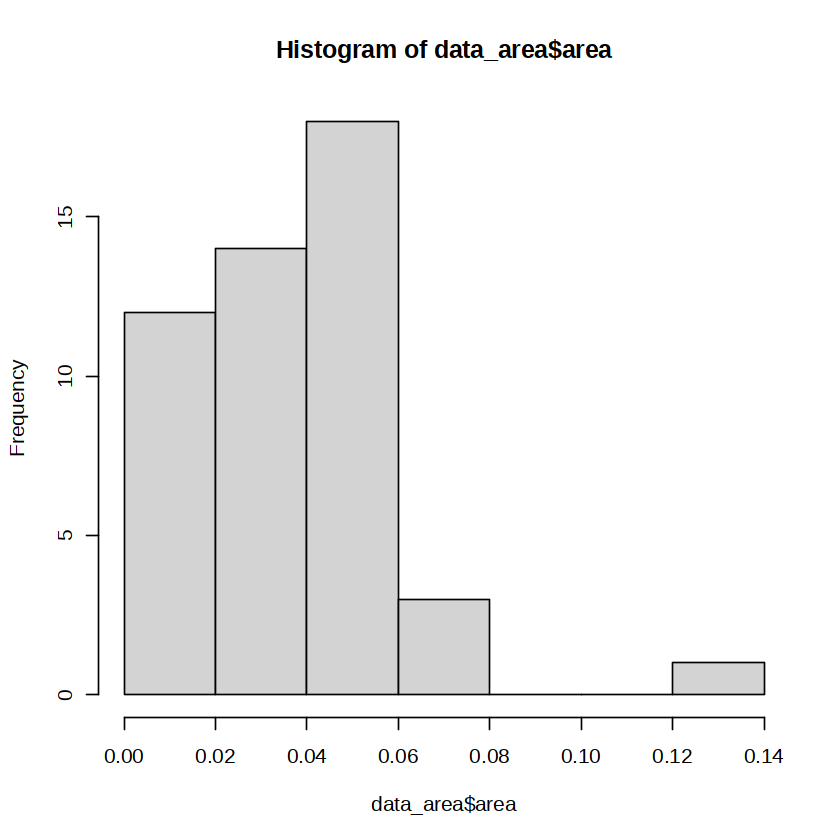

[1] 0.11959684 0.22800762 0.11067629 0.24653859 0.20260277 0.19722286
 [7] 0.21276708 0.18710921 0.24239008 0.16233434 0.15786965 0.19062778
[13] 0.23334011 0.14144425 0.11223408 0.23963155 0.20911934 0.22524706
[19] 0.16793687 0.17737616 0.11773960 0.25404861 0.24419876 0.24282215
[25] 0.24472652 0.11347795 0.13367890 0.24127942 0.22174041 0.11398800
[31] 0.12530533 0.21240579 0.25197557 0.07931746 0.35555719 0.21008214
[37] 0.16972636 0.13644982 0.16672583 0.23793673 0.17270648 0.17919471
[43] 0.10959938 0.15249563 0.10723851 0.22874830 0.22946542 0.19378940

boundary (singular) fit: see help('isSingular')

Warning message in as_lmerModLT(model, devfun):
“Model may not have converged with 1 eigenvalue close to zero: 1.6e-12”


(Intercept) continent habitat range var_explained1 var_explained2
25  0.10601682  NA        NA      NA    0.3241574      1.4865854     
17  0.13537053  NA        NA      NA           NA      3.1941249     
9   0.12502947  NA        NA      NA    0.3557199             NA     
1   0.18800133  NA        NA      NA           NA             NA     
29  0.10952306  NA        NA      +     0.3350025      1.2811078     
21  0.13552517  NA        NA      +            NA      3.2164873     
27  0.10241977  NA        +       NA    0.3241574      1.4865854     
19  0.13176099  NA        +       NA           NA      3.1918429     
13  0.12618002  NA        NA      +     0.3642120             NA     
11  0.12143242  NA        +       NA    0.3557199             NA     
5   0.18949851  NA        NA      +            NA             NA     
3   0.18435501  NA        +       NA           NA             NA     
23  0.13190571  NA        +       +            NA      3.2157386     
31  0.10592601  NA        +       +     0.3350025      1.2811078     
15  0.12258297  NA        +       +     0.3642120             NA     
7   0.18588184  NA        +       +            NA             NA     
87  0.13677112  NA        +       +            NA      3.2156368     
95  0.11079433  NA        +       +     0.3350025      1.2811078     
79  0.12745129  NA        +       +     0.3642120             NA     
71  0.19074699  NA        +       +            NA             NA     
18  0.13947671  +         NA      NA           NA      3.0590011     
2   0.18739218  +         NA      NA           NA             NA     
26  0.09824445  +         NA      NA    0.3200156      1.0229843     
10  0.10703382  +         NA      NA    0.3516759             NA     
22  0.13952842  +         NA      +            NA      3.0556998     
30  0.08502714  +         NA      +     0.4215751      0.3852611     
6   0.18739218  +         NA      +            NA             NA     
14  0.08734072  +         NA      +     0.4378597             NA     
20  0.13587966  +         +       NA           NA      3.0590011     
4   0.18379514  +         +       NA           NA             NA     
28  0.09464741  +         +       NA    0.3200156      1.0229843     
12  0.10343678  +         +       NA    0.3516759             NA     
24  0.13593138  +         +       +            NA      3.0556998     
8   0.18379514  +         +       +            NA             NA     
32  0.08143010  +         +       +     0.4215751      0.3852611     
16  0.08374368  +         +       +     0.4378597             NA     
88  0.14079969  +         +       +            NA      3.0556998     
72  0.18866345  +         +       +            NA             NA     
80  0.08861199  +         +       +     0.4378597             NA     
96  0.08629841  +         +       +     0.4215751      0.3852611     
52  0.18542464  +         +       NA           NA      3.0590011     
36  0.23334011  +         +       NA           NA             NA     
44  0.15298176  +         +       NA    0.3516759             NA     
60  0.14419238  +         +       NA    0.3200156      1.0229843     
56  0.18547635  +         +       +            NA      3.0556998     
40  0.23334011  +         +       +            NA             NA     
48  0.13328865  +         +       +     0.4378597             NA     
64  0.13097507  +         +       +     0.4215751      0.3852611     
120 0.18547635  +         +       +            NA      3.0556998     
104 0.23334011  +         +       +            NA             NA     
112 0.13328865  +         +       +     0.4378597             NA     
128 0.13097507  +         +       +     0.4215751      0.3852611     
    continent:habitat habitat:range df logLik   AICc       delta     
25  NA                NA             6 71.36449 -128.68020  0.0000000
17  NA                NA             5 69.93336 -128.43816  0.2420449
9   NA                NA             5 69.42056 -127.41255  1.2676515
1   NA        

boundary (singular) fit: see help('isSingular')



Sum Sq       Mean Sq      NumDF DenDF F value   Pr(>F)    
habitat        0.0006210591 0.0006210591 1     44    0.2199306 0.64140824
var_explained1 0.0142124928 0.0142124928 1     44    5.0329545 0.02995315
var_explained2 0.0012221259 0.0012221259 1     44    0.4327815 0.51405452

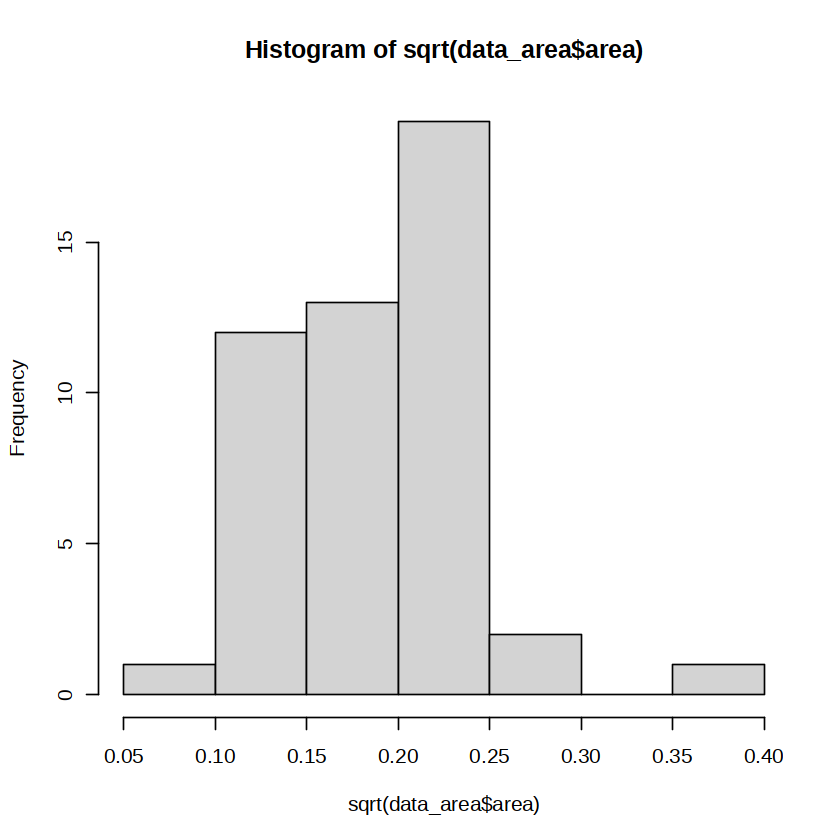

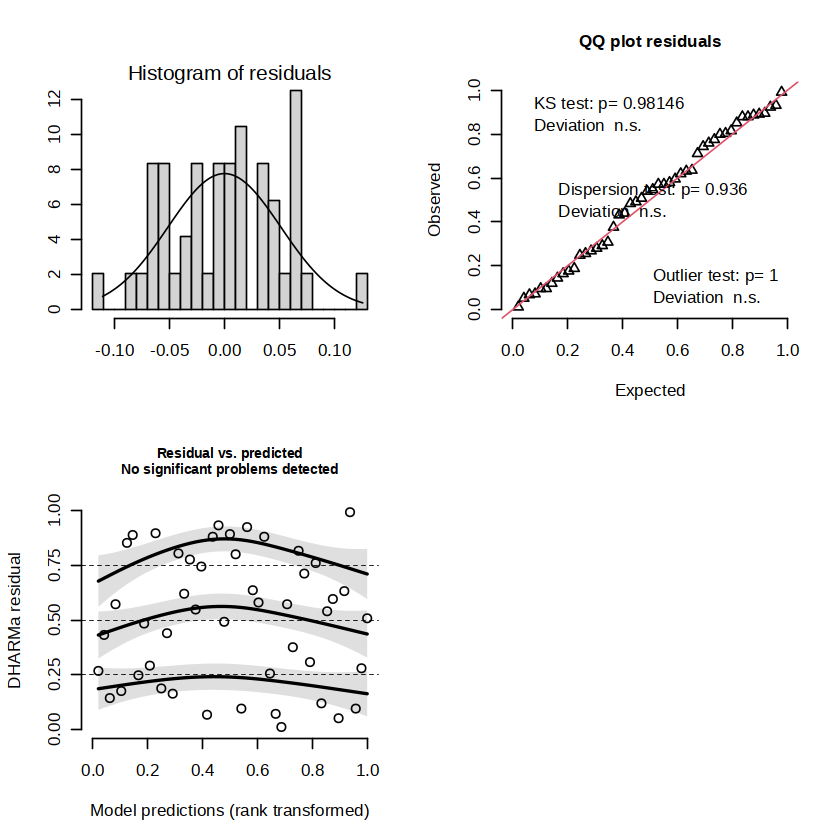

In [44]:
data_area<-read.csv("/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses//analyses/tables/pca_ellipse_areas.csv")
#head(data_area)

hist(data_area$area)
#hist(log(data_area$area))
hist(sqrt(data_area$area))
sqrt(data_area$area)
data_area$sqrt_area<-sqrt(data_area$area)


mod_area<-lmer(sqrt_area ~ habitat+continent+range+ var_explained1 + var_explained2 + +habitat*continent+habitat*range + (1|continent/city), data=data_area,na.action=na.fail)
#mod<-dredge(mod_area, trace=T, rank="AICc")
mod
best_model<-lmer(sqrt_area ~ habitat + var_explained1 + var_explained2+ (1|city), data=data_area,na.action=na.fail)
anova(best_model)

#check fit
diagnostics.plot.dharma <-function(mod.res, col=grey(level=0.25, alpha=0.5), breaks.histo=20, quantreg=TRUE){
  old.par = par(no.readonly = TRUE)
  par(mfrow=c(2, 2))
  hist(residuals(mod.res), probability=T, xlab="", ylab="", main="", breaks=breaks.histo)
  mtext(text="Histogram of residuals", side=3, line=0)
  x=seq(min(residuals(mod.res)), max(residuals(mod.res)), length.out=100)
  lines(x, dnorm(x, mean=0, sd=sd(residuals(mod.res))))
  simulationOutput <- simulateResiduals(fittedModel = mod.res, plot = FALSE)
  plotQQunif(simulationOutput) # left plot in plot.DHARMa()
  plotResiduals(simulationOutput, quantreg=quantreg)
}
diagnostics.plot.dharma(best_model)


city         overlap   var_explained1 var_explained2 continent range     
1 Albuquerque  0.1299369 0.1640142      0.01313789     NAM       Introduced
2 Antwerp      0.1979634 0.1750589      0.01423548     EU        Native    
3 Armidale     0.3439625 0.1915336      0.01405180     OCE       Introduced
4 Athens       0.6019042 0.1676150      0.01459251     NAM       Introduced
5 Buenos_Aires 0.4025103 0.1809898      0.01377522     SAM       Introduced
6 Calgary      0.3980147 0.1401211      0.01462214     NAM       Introduced

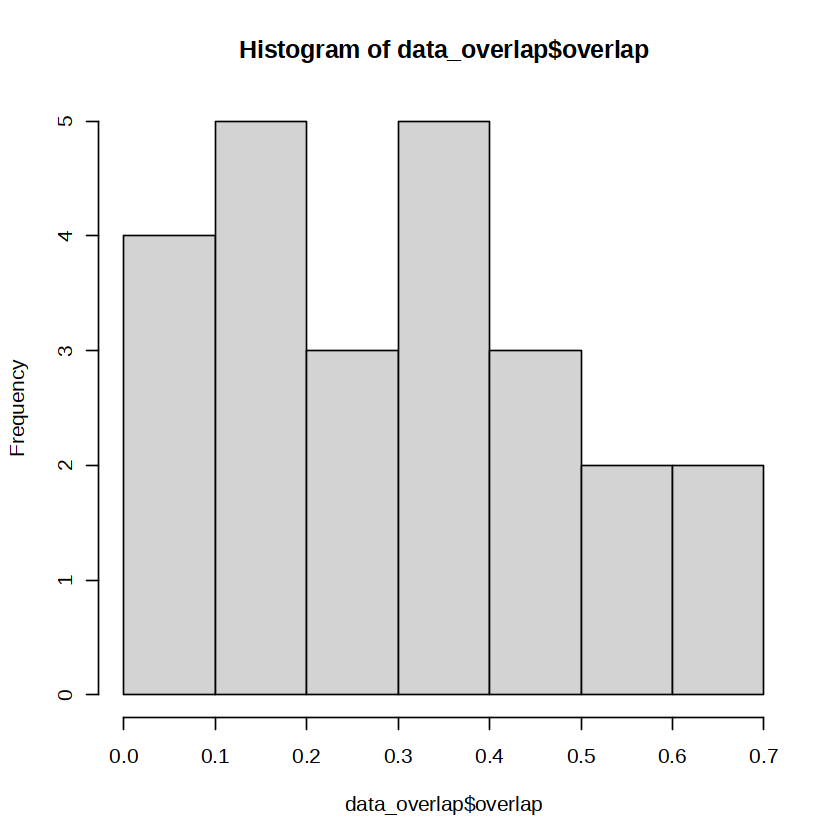

Df Sum Sq     Mean Sq    F value   Pr(>F)   
continent       5 0.07739603 0.01547921 0.3859072 0.8507484
range           1 0.02969279 0.02969279 0.7402614 0.4031201
var_explained1  1 0.06439675 0.06439675 1.6054549 0.2244518
var_explained2  1 0.01234262 0.01234262 0.3077099 0.5872657
Residuals      15 0.60166827 0.04011122        NA        NA

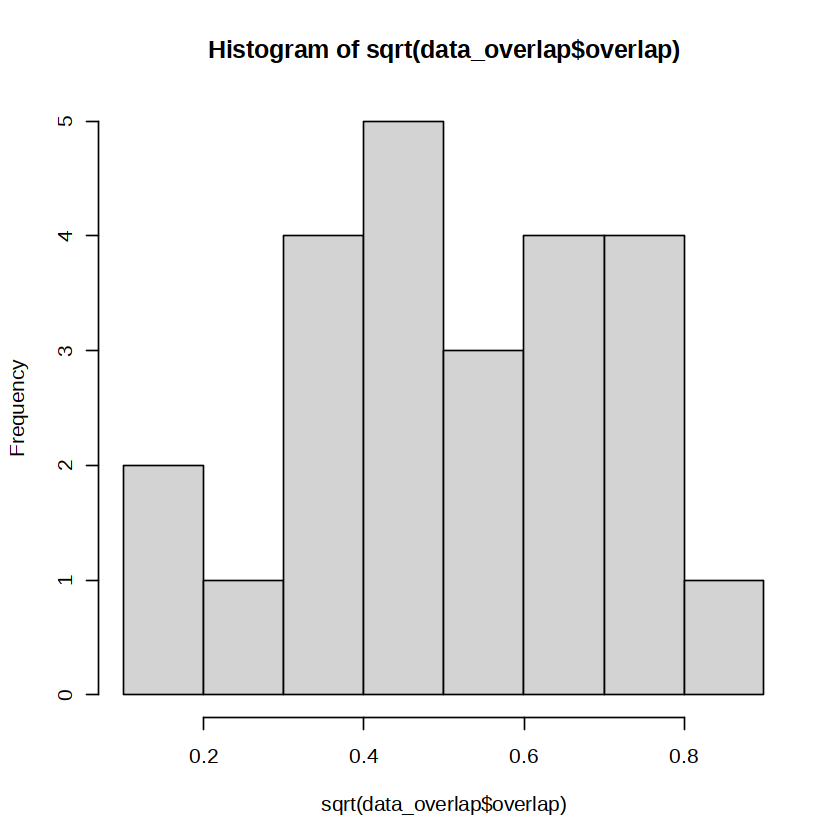

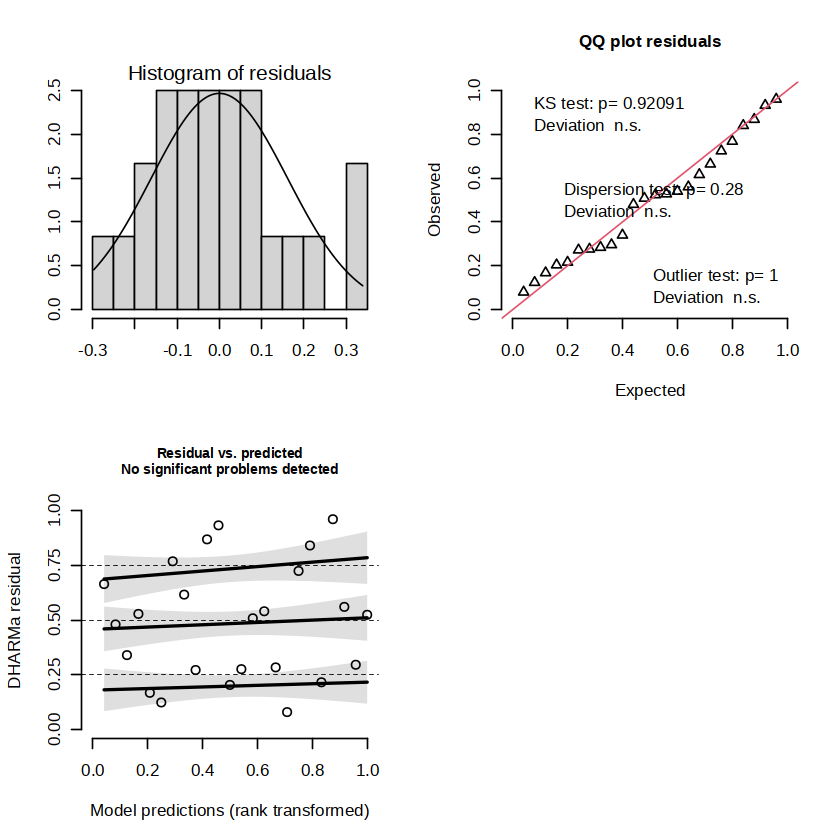

In [55]:
data_overlap<-read.csv("/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/tables/pca_ellipse_overlap.csv")
head(data_overlap)

hist(data_overlap$overlap)
hist(sqrt(data_overlap$overlap))


mod_overlap<-lm(overlap ~ continent+range+ var_explained1 + var_explained2 , data=data_overlap, na.action=na.fail)
anova(mod_overlap)
#Does model selection makes any sense here ?
#mod<-dredge(mod_overlap, trace=T, rank="AICc")
#mod
#best_model<-lm(overlap ~  var_explained1 + var_explained2, data=data_overlap)
#anova(best_model)

#check fit
diagnostics.plot.dharma <-function(mod.res, col=grey(level=0.25, alpha=0.5), breaks.histo=20, quantreg=TRUE){
  old.par = par(no.readonly = TRUE)
  par(mfrow=c(2, 2))
  hist(residuals(mod.res), probability=T, xlab="", ylab="", main="", breaks=breaks.histo)
  mtext(text="Histogram of residuals", side=3, line=0)
  x=seq(min(residuals(mod.res)), max(residuals(mod.res)), length.out=100)
  lines(x, dnorm(x, mean=0, sd=sd(residuals(mod.res))))
  simulationOutput <- simulateResiduals(fittedModel = mod.res, plot = FALSE)
  plotQQunif(simulationOutput) # left plot in plot.DHARMa()
  plotResiduals(simulationOutput, quantreg=quantreg)
}
diagnostics.plot.dharma(mod_overlap)
